# Přísnost známkování na PISA 2018

Finální verze:
- pystata + magics umožňují interakci mezi Statou a Pythonem, to je hodně cool
- analýza pouze známek z matematiky, celý vzorek je vyfiltrován:
    - žáci 9. ročníků ze ZŠ
    - uvedli validní známku z matematiky, mají ECSC
- v grafech podle přísnosti vynecháni žáci se známkou 5 (too noisy)
- školy rozděleny na 3 kategorie podle přísnosti známkování (uvidíme, jak to vypadá)
- přísnost založena na rovnici (ESCS = index of economic, social and cultural status) - odhadnu mixed effects model (s plausible values a dvouúrovňovými váhami), následně napočítám průměrná školní rezidua:

$$\mathrm{GRADE}_{ij} = \beta_0 + \beta_1 \cdot \mathrm{SCORE}_{ij} + \beta_2 \cdot \mathrm{GIRL}_{ij} + \beta_3 \cdot \mathrm{ESCS}_{ij} + \mathrm{SCHOOL}_j + \varepsilon_{ij}$$

## Imports

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['figure.figsize'] = 10, 5
#plt.ioff()
import stata_setup
stata_setup.config('/usr/local/stata17', 'be')
from pystata import stata


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       BE—Basic Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user , expiring 16 Apr 2023
Serial number: 301709041865
  Licensed to: Tomas Protivinsky
               CERGE-EI

Notes:
      1. Unicode is supported; see help unicode_advice.


In [2]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

## Stata data loading

In [4]:
%%stata -qui

// kod
clear all
version 17
set more off
// global path to data
global PATHD="/mnt/d/projects/idea/data"

// load students data
import spss ${PATHD}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav, clear

// zde spoléhám na to, že pohlaví mám u všech - v datasetu to platí
gen girl = (ST004D01T == 1)
keep if (ST001D01T == "Grade 9":labels3 & STRATUMID_rec == "ZŠ":labels2)

gen gr_matematika = ST800C01HA_CZ
recode gr_matematika 3=5 5=3 6=.
egen gr_matematika_z = std(gr_matematika)

// all this stuff has to be run at once
tempfile stu18
save `stu18'

// load school data
import spss ${PATHD}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav, clear
keep CNTSCHID W_SCHGRNRABWT
tempfile sch18
save `sch18'

use `stu18'
merge m:1 CNTSCHID using `sch18'
// je dobré zkontrolovat, že je to v pořádku namergované - zde je to ok
drop if _merge==2 

// multiple imputations to handle plausible values
gen math=1/0
mi import wide, imputed(math=PV*MATH) clear

mi passive: egen mathz = std(math)
egen ESCSz = std(ESCS)

// drop incomplete data
drop if missing(gr_matematika) | missing(ESCS)

In [5]:
%stata count

  1,871


## Basic descriptives

- grade frequencies by gender
- lineplot with standard errors (nebo CIs?)
- boxplots by grades

### Grade frequencies

In [6]:
df = stata.pdataframe_from_data()

# Stata uses something like 1e307 as nan in the converted frame
for c in df.columns:
    if df[c].dtype == np.float_:
        df.loc[df[c] > 1e300, c] = np.nan

In [7]:
df.head()

,CNTSTUID,CNTSCHID,CNTRYID,STRATUM,STRATUMID_rec,ST001D01T,ST003D02T,ST003D03T,ST004D01T,ST005Q01TA,...,_2_mathz,_3_mathz,_4_mathz,_5_mathz,_6_mathz,_7_mathz,_8_mathz,_9_mathz,_10_mathz,ESCSz
0,20304622,20300002,203,CZE0606,1,9,5,2002,2,2.0,...,-0.386107,-0.079972,-0.199261,-0.375973,0.225695,0.189687,-0.723216,-1.133832,-0.963760,0.344877
1,20307274,20300002,203,CZE0606,1,9,12,2002,1,2.0,...,0.271197,-0.579686,-0.207105,-0.508854,0.643913,-0.803780,0.502597,-0.492806,-0.628544,-0.427120
2,20300029,20300002,203,CZE0606,1,9,6,2002,2,1.0,...,-1.933687,-0.950177,-0.214975,-0.563806,-1.349020,-1.269906,-0.921567,0.032300,-1.923861,-0.203379
3,20301624,20300002,203,CZE0606,1,9,2,2002,2,2.0,...,-1.824182,-1.420534,-0.564678,-1.236574,-0.875265,-0.913101,-2.476740,-1.632807,-1.057256,-0.800750
4,20300521,20300002,203,CZE0606,1,9,10,2002,1,1.0,...,0.308114,0.022139,0.536961,0.504654,0.113840,0.622679,-0.371601,-0.200786,-0.017800,1.629721


In [8]:
df['girl'].value_counts()

0.0    1033
1.0     838
Name: girl, dtype: int64

In [8]:
df.shape

(1871, 753)

In [9]:
df['CNTSCHID'].unique().shape

(128,)

In [28]:
plt.rcParams['figure.subplot.top'] = 0.92

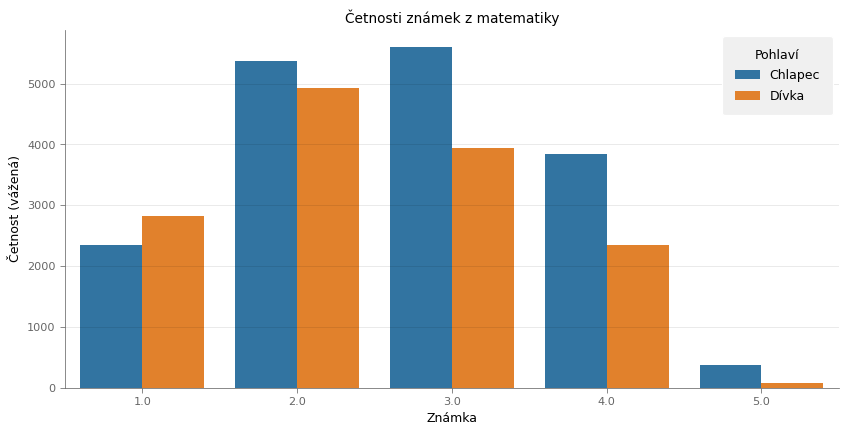

In [29]:
foo = df.groupby(['gr_matematika', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='gr_matematika', y='W_FSTUWT', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost (vážená)')
ax.set_title('Četnosti známek z matematiky')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Chlapec', 'Dívka'], title='Pohlaví')

In [31]:
foo = df.groupby(['gr_matematika', 'girl'])['W_FSTUWT'].sum().reset_index()
gender_total = foo.groupby('girl')['W_FSTUWT'].sum().rename('gender_weight').reset_index()
foo = pd.merge(foo, gender_total)
foo['rel_weight'] = foo['W_FSTUWT'] / foo['gender_weight']
foo['rel_weight_pct'] = 100 * foo['rel_weight']
foo

,gr_matematika,girl,W_FSTUWT,gender_weight,rel_weight,rel_weight_pct
0,1.0,0.0,2346.70889,17538.95343,0.133800,13.379982
1,2.0,0.0,5374.89499,17538.95343,0.306455,30.645472
2,3.0,0.0,5604.00630,17538.95343,0.319518,31.951771
3,4.0,0.0,3845.94832,17538.95343,0.219280,21.928038
4,5.0,0.0,367.39493,17538.95343,0.020947,2.094737
5,1.0,1.0,2822.08362,14094.43147,0.200227,20.022685
6,2.0,1.0,4927.20088,14094.43147,0.349585,34.958493
7,3.0,1.0,3936.48293,14094.43147,0.279293,27.929349
8,4.0,1.0,2339.65236,14094.43147,0.165998,16.599835
9,5.0,1.0,69.01168,14094.43147,0.004896,0.489638


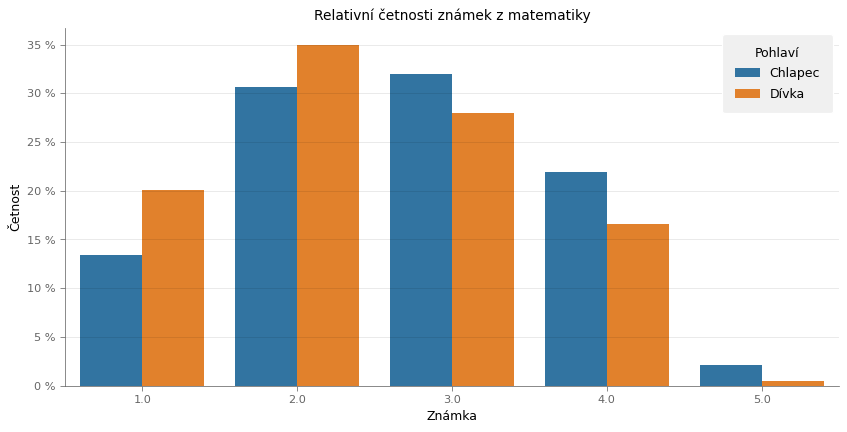

In [32]:
ax = sns.barplot(x='gr_matematika', y='rel_weight_pct', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost')
ax.set_title('Relativní četnosti známek z matematiky')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Chlapec', 'Dívka'], title='Pohlaví')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))

In [33]:
ax.get_figure().savefig('output/prisnost-znamkovani/01-cetnost-znamek.png')
ax.get_figure().savefig('output/prisnost-znamkovani/01-cetnost-znamek.pdf')

In [14]:
foo

,gr_matematika,girl,W_FSTUWT
0,1.0,0.0,2346.70889
1,1.0,1.0,2822.08362
2,2.0,0.0,5374.89499
3,2.0,1.0,4927.20088
4,3.0,0.0,5604.00630
5,3.0,1.0,3936.48293
6,4.0,0.0,3845.94832
7,4.0,1.0,2339.65236
8,5.0,0.0,367.39493
9,5.0,1.0,69.01168


In [15]:
%stata mi estimate, dots: reg math [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.6448
                                                Largest FMI       =     0.4121
                                                Complete DF       =       1870
                                                DF:     min       =      55.69
                                                        avg       =      55.69
DF adjustment:   Small sample                           max       =      55.69
                                                F(   0,      .)   =          .
Within VCE type:       Robust                   Prob > F          =          .

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [34]:
%stata mi estimate, dots: reg math ibn.gr_matematika#ibn.girl [pw = W_FSTUWT], noconstant


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.3635
                                                Largest FMI       =     0.4514
                                                Complete DF       =       1861
DF adjustment:   Small sample                   DF:     min       =      46.75
                                                        avg       =     153.30
                                                        max       =     274.97
Model F test:       Equal FMI                   F(  10,  717.1)   =    5804.36
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [35]:
er = stata.get_ereturn()
coefs = er['e(b_mi)']
std_errs = np.sqrt(np.diag(er['e(V_mi)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['gr_matematika'] = foo.index // 2 + 1
foo['girl'] = foo.index % 2
foo['gr_matematika_dodged'] = foo['gr_matematika'] - 0.1 + 0.2 * foo['girl']
foo

,coef,se,lc,uc,gr_matematika,girl,gr_matematika_dodged
0,544.009517,8.245125,527.838851,560.180182,1,0,0.9
1,534.864422,7.018233,521.099987,548.628858,1,1,1.1
2,518.772500,4.627405,509.697051,527.847950,2,0,1.9
3,493.235957,5.009285,483.411550,503.060364,2,1,2.1
4,462.258734,4.733065,452.976060,471.541408,3,0,2.9
5,441.979536,5.406247,431.376591,452.582481,3,1,3.1
6,432.997833,5.416875,422.374043,443.621623,4,0,3.9
7,405.725684,6.772069,392.444033,419.007334,4,1,4.1
8,411.850788,21.810530,369.075116,454.626461,5,0,4.9
9,378.407758,38.720476,302.467629,454.347886,5,1,5.1


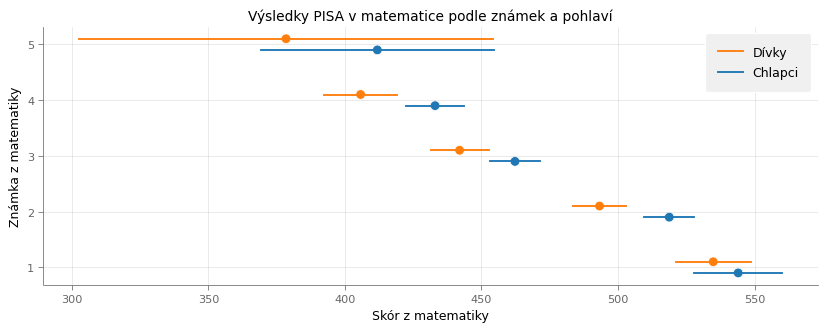

In [36]:
cur_palette = sns.color_palette(n_colors=2)

fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='gr_matematika_dodged', data=foo, hue='girl', palette=cur_palette, legend=False, s=60)
for i in range(10):
    plt.plot(foo.loc[i, ['lc', 'uc']], [foo.loc[i, 'gr_matematika_dodged'], foo.loc[i, 'gr_matematika_dodged']], color=cur_palette[i % 2], lw=1.5)
ax.set(xlabel='Skór z matematiky', ylabel='Známka z matematiky', title='Výsledky PISA v matematice podle známek a pohlaví')

plt.legend(ax.lines[1::-1], ['Dívky', 'Chlapci'])

None

In [ ]:
ax.get_figure().savefig('output/prisnost-znamkovani/03-prumerne-skory-pohlavi.png')
ax.get_figure().savefig('output/prisnost-znamkovani/03-prumerne-skory-pohlavi.pdf')

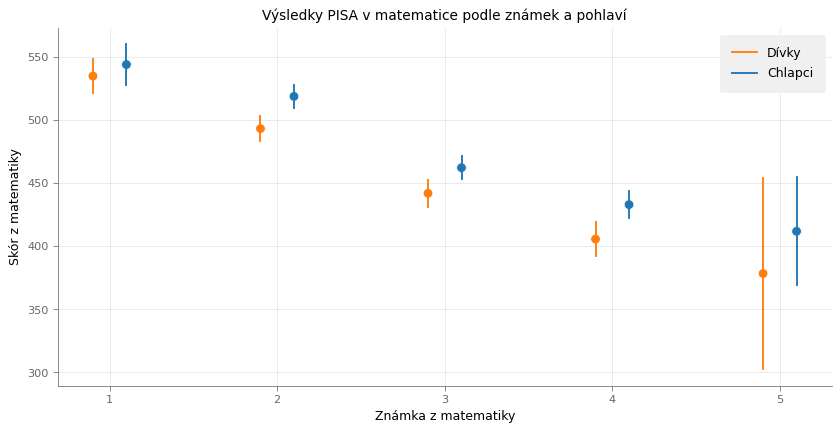

In [39]:
foo['gr_matematika_dodged'] = foo['gr_matematika'] + 0.1 - 0.2 * foo['girl']

cur_palette = sns.color_palette(n_colors=2)

# fig, ax = plt.subplots(figsize=(10, 3.6))
fig, ax = plt.subplots()
sns.scatterplot(x='gr_matematika_dodged', y='coef', data=foo, hue='girl', palette=cur_palette, legend=False, s=60)
for i in range(10):
    plt.plot([foo.loc[i, 'gr_matematika_dodged'], foo.loc[i, 'gr_matematika_dodged']], foo.loc[i, ['lc', 'uc']], color=cur_palette[i % 2], lw=1.5)
ax.set(xlabel='Známka z matematiky', ylabel='Skór z matematiky', title='Výsledky PISA v matematice podle známek a pohlaví')

plt.legend(ax.lines[1::-1], ['Dívky', 'Chlapci'])

None

In [40]:
ax.get_figure().savefig('output/prisnost-znamkovani/03-prumerne-skory-pohlavi-otoceny.png')
ax.get_figure().savefig('output/prisnost-znamkovani/03-prumerne-skory-pohlavi-otoceny.pdf')

In [377]:
%stata reg ESCS girl [pw = W_FSTUWT]

(sum of wgt is 31,633.3849)

Linear regression                               Number of obs     =      1,871
                                                F(1, 1869)        =       0.85
                                                Prob > F          =     0.3577
                                                R-squared         =     0.0005
                                                Root MSE          =     .79208

------------------------------------------------------------------------------
             |               Robust
        ESCS | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
        girl |  -.0356504   .0387488    -0.92   0.358    -.1116458     .040345
       _cons |  -.3303257   .0267399   -12.35   0.000    -.3827688   -.2778825
------------------------------------------------------------------------------


In [380]:
%stata mi estimate, dots: reg math ibn.gr_matematika#ibn.ESCS_high [pw = W_FSTUWT], noconstant


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.3167
                                                Largest FMI       =     0.4009
                                                Complete DF       =       1861
DF adjustment:   Small sample                   DF:     min       =      58.69
                                                        avg       =     184.75
                                                        max       =     456.21
Model F test:       Equal FMI                   F(  10,  809.0)   =    6035.57
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [379]:
%stata mi estimate, dots: reg math ibn.gr_matematika#ibn.ESCS_high [pw = W_FSTUWT], noconstant vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.2904
                                                Largest FMI       =     0.3546
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      40.95
                                                        avg       =      70.91
                                                        max       =     111.07
Model F test:       Equal FMI                   F(  10,  114.5)   =    2297.71
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
        math

In [381]:
er = stata.get_ereturn()
coefs = er['e(b_mi)']
std_errs = np.sqrt(np.diag(er['e(V_mi)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['gr_matematika'] = foo.index // 2 + 1
foo['ESCS_high'] = foo.index % 2
foo['gr_matematika_dodged'] = foo['gr_matematika'] - 0.1 + 0.2 * foo['ESCS_high']
foo

,coef,se,lc,uc,gr_matematika,ESCS_high,gr_matematika_dodged
0,516.135080,9.190025,498.111240,534.158921,1,0,0.9
1,552.264590,6.261978,539.983351,564.545829,1,1,1.1
2,493.942073,5.175624,483.791434,504.092712,2,0,1.9
3,518.836458,4.591617,509.831198,527.841718,2,1,2.1
4,448.658861,4.555140,439.725140,457.592581,3,0,2.9
5,463.132359,5.654779,452.041982,474.222735,3,1,3.1
6,418.779631,4.999979,408.973475,428.585787,4,0,3.9
7,433.057260,7.696006,417.963550,448.150971,4,1,4.1
8,400.229745,20.515618,359.993704,440.465786,5,0,4.9
9,432.393321,46.904087,340.403171,524.383471,5,1,5.1


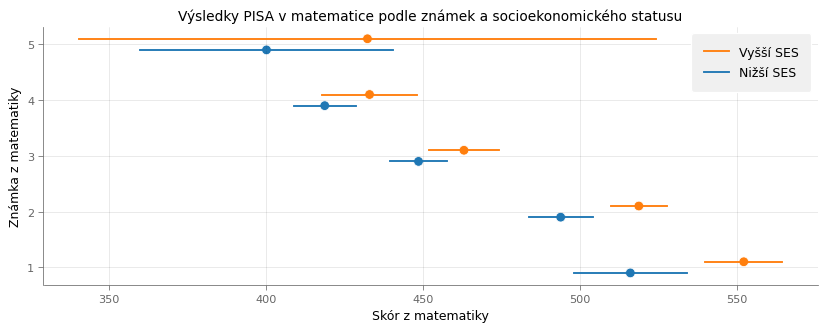

In [383]:
cur_palette = sns.color_palette(n_colors=2)

fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='gr_matematika_dodged', data=foo, hue='ESCS_high', palette=cur_palette, legend=False, s=60)
for i in range(10):
    plt.plot(foo.loc[i, ['lc', 'uc']], [foo.loc[i, 'gr_matematika_dodged'], foo.loc[i, 'gr_matematika_dodged']], color=cur_palette[i % 2], lw=1.5)
ax.set(xlabel='Skór z matematiky', ylabel='Známka z matematiky', title='Výsledky PISA v matematice podle známek a socioekonomického statusu')

plt.legend(ax.lines[1::-1], ['Vyšší SES', 'Nižší SES'])

None

In [ ]:
ax.get_figure().savefig('output/prisnost-znamkovani/03b-prumerne-skory-ses.png')
ax.get_figure().savefig('output/prisnost-znamkovani/03b-prumerne-skory-ses.pdf')

### Lineplot

In [19]:
%stata mi estimate, dots: reg math ibn.gr_matematika [pw = W_FSTUWT], noconstant


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.3680
                                                Largest FMI       =     0.3540
                                                Complete DF       =       1866
DF adjustment:   Small sample                   DF:     min       =      74.23
                                                        avg       =     129.92
                                                        max       =     233.80
Model F test:       Equal FMI                   F(   5,  413.2)   =   11142.30
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [20]:
er = stata.get_ereturn()
b_mi = er['e(b_mi)']
V_mi = er['e(V_mi)']
dfr = er['e(df_r_mi)']
coefs = b_mi[0]
std_errs = np.sqrt(np.diag(V_mi))

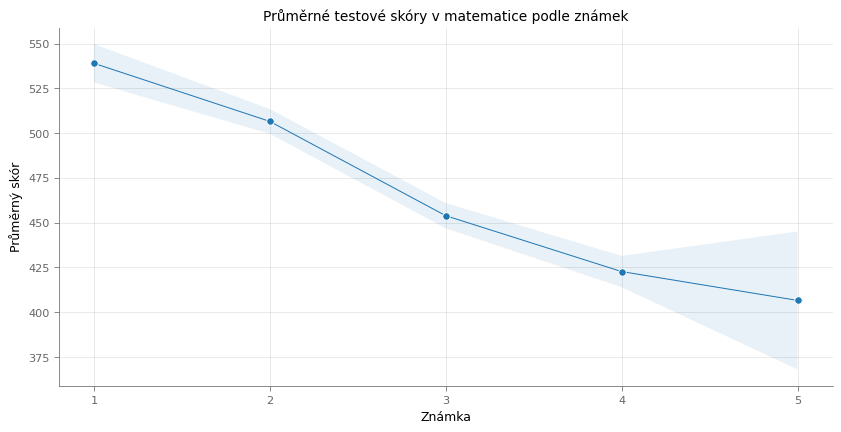

In [21]:
foo = pd.DataFrame({'grade': range(1, 6), 'coef': coefs, 'se': std_errs})

foo['lower'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['upper'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']

fig, ax = plt.subplots()
sns.lineplot(x='grade', y='coef', data=foo, marker='o')
plt.fill_between(foo['grade'], foo['lower'], foo['upper'], alpha=0.1)
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v matematice podle známek')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))

In [ ]:
ax.get_figure().savefig('output/prisnost-znamkovani/02-prumerne-skory.png')
ax.get_figure().savefig('output/prisnost-znamkovani/02-prumerne-skory.pdf')

In [22]:
foo

,grade,coef,se,lower,upper
0,1,539.016432,5.443552,528.315927,549.716936
1,2,506.559095,3.518873,499.641971,513.476218
2,3,453.891373,3.579601,446.854876,460.927871
3,4,422.682368,4.438170,413.958164,431.406572
4,5,406.562235,19.591409,368.050987,445.073483


### Boxplots

In [41]:
boxplots = []

bxp_def = {
    'med': 0.5,
    'q1': 0.25,
    'q3': 0.75,
    'whislo': 0.05,
    'whishi': 0.95
}


for gr in range(1, 6):
    print(f'running {gr}')
    inner = {}
    inner['label'] = gr
    inner['fliers'] = []
    if gr < 5:
        cmd = 'qreg math [pw = W_FSTUWT]'
    else:
        cmd = 'bsqreg math'
    for lbl, q in bxp_def.items():        
        stata.run(f'''
            preserve
            keep if gr_matematika == {gr}
            mi estimate, dots: {cmd}, q({q})
            restore
        ''', quietly=True)
        inner[lbl] = stata.get_ereturn()['e(b_mi)'][0][0]
    boxplots.append(inner)

running 1





running 2





running 3





running 4





running 5







[Text(0.5, 1.0, 'PISA 2018: Testové skóry v matematice podle známek'),
 Text(0.5, 0, 'Testový skór'),
 Text(0, 0.5, 'Známka')]

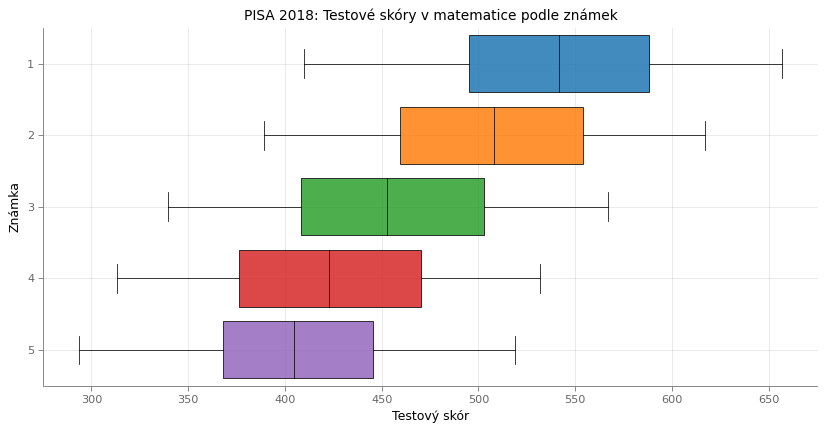

In [42]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = sns.color_palette(n_colors=5)

boxes = ax.bxp(boxplots, vert=False, positions=range(6, 1, -1), widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    bx.set_facecolor([*pal[i], 0.85])
None

ax.set(title='PISA 2018: Testové skóry v matematice podle známek', xlabel='Testový skór', ylabel='Známka')

In [ ]:
ax.get_figure().savefig('output/prisnost-znamkovani/04-prumerne-skory-boxploty.png')
ax.get_figure().savefig('output/prisnost-znamkovani/04-prumerne-skory-boxploty.pdf')

[Text(0.5, 1.0, 'PISA 2018: Testové skóre v matematice podle známek'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Testové skóre')]

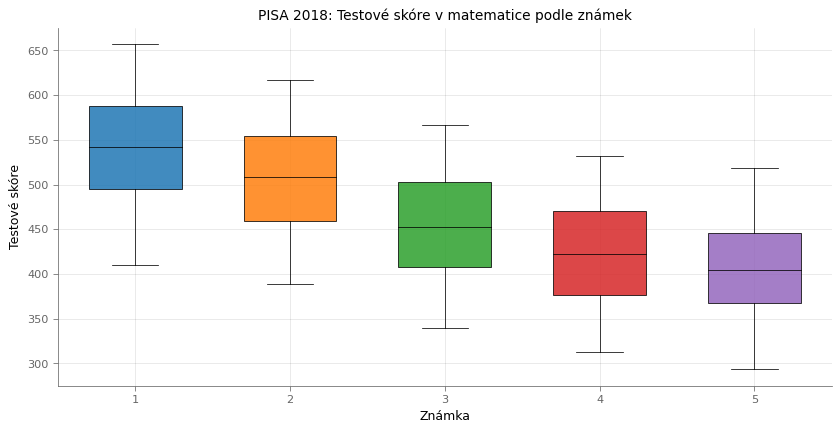

In [48]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = sns.color_palette(n_colors=5)

boxes = ax.bxp(boxplots, vert=True, positions=range(1, 6), widths=0.6, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    bx.set_facecolor([*pal[i], 0.85])
None

ax.set(title='PISA 2018: Testové skóre v matematice podle známek', xlabel='Známka', ylabel='Testové skóre')

In [49]:
ax.get_figure().savefig('output/prisnost-znamkovani/04-prumerne-skory-boxploty-otoceny.png')
ax.get_figure().savefig('output/prisnost-znamkovani/04-prumerne-skory-boxploty-otoceny.pdf')

In [45]:
pd.DataFrame(boxplots).drop(columns=['fliers']).rename(columns={'label': 'grade'})

,grade,med,q1,q3,whislo,whishi
0,1,541.836609,495.014703,588.191992,409.629999,657.039392
1,2,508.096695,459.597101,554.233197,389.074396,616.928802
2,3,452.747098,408.117203,503.108902,339.710901,567.076697
3,4,422.600204,376.473300,470.155600,313.184003,531.917596
4,5,404.865701,367.994797,445.333698,293.413599,519.075894


In [132]:
%%stata
local M = 10
scalar r2 = 0
qui mi xeq 1/`M': reg math ibn.gr_matematika [pw = W_FSTUWT], noconstant; scalar r2 = r2 + atanh(sqrt(e(r2)))
scalar r2 = tanh(r2/`M')^2
di as txt "R2 using Fisher's z over imputed data = " as res r2


. local M = 10

. scalar r2 = 0

. qui mi xeq 1/`M': reg math ibn.gr_matematika [pw = W_FSTUWT], noconstant; sca
> lar r2 = r2 + atanh(sqrt(e(r2)))

. scalar r2 = tanh(r2/`M')^2

. di as txt "R2 using Fisher's z over imputed data = " as res r2
R2 using Fisher's z over imputed data = .97920395

. 


## Model a přísnost jednotlivých škol

In [51]:
%stata mi estimate, dots: mixed gr_matematika mathz girl ESCSz [pw = W_FSTUWT] || CNTSCHID: , pweight (W_SCHGRNRABWT) pwscale(size)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Mixed-effects regression                        Number of obs     =      1,871

Group variable: CNTSCHID                        Number of groups  =        128
                                                Obs per group:
                                                              min =          1
                                                              avg =       14.6
                                                              max =         34
                                                Average RVI       =     0.1639
                                                Largest FMI       =     0.2829
DF adjustment:   Large sample                   DF:     min       =     122.32
                                                        avg       =   1,301.00
                                                        max       =   4,324.62
Model F test:       Equal FM

In [52]:
coefs = stata.get_ereturn()['e(b_mi)'][0]

In [53]:
coefs  # 5th and 6th are logs of estimated std devs (why logs?)

array([-0.50675392, -0.33512066, -0.15307308,  2.70381206, -1.47251757,
       -0.18827643])

In [54]:
df.head()

,CNTSTUID,CNTSCHID,CNTRYID,STRATUM,STRATUMID_rec,ST001D01T,ST003D02T,ST003D03T,ST004D01T,ST005Q01TA,...,_2_mathz,_3_mathz,_4_mathz,_5_mathz,_6_mathz,_7_mathz,_8_mathz,_9_mathz,_10_mathz,ESCSz
0,20304622,20300002,203,CZE0606,1,9,5,2002,2,2.0,...,-0.386107,-0.079972,-0.199261,-0.375973,0.225695,0.189687,-0.723216,-1.133832,-0.963760,0.344877
1,20307274,20300002,203,CZE0606,1,9,12,2002,1,2.0,...,0.271197,-0.579686,-0.207105,-0.508854,0.643913,-0.803780,0.502597,-0.492806,-0.628544,-0.427120
2,20300029,20300002,203,CZE0606,1,9,6,2002,2,1.0,...,-1.933687,-0.950177,-0.214975,-0.563806,-1.349020,-1.269906,-0.921567,0.032300,-1.923861,-0.203379
3,20301624,20300002,203,CZE0606,1,9,2,2002,2,2.0,...,-1.824182,-1.420534,-0.564678,-1.236574,-0.875265,-0.913101,-2.476740,-1.632807,-1.057256,-0.800750
4,20300521,20300002,203,CZE0606,1,9,10,2002,1,1.0,...,0.308114,0.022139,0.536961,0.504654,0.113840,0.622679,-0.371601,-0.200786,-0.017800,1.629721


In [55]:
for i in range(1,11):
    df[f'PV{i}MATHz'] = (df[f'PV{i}MATH'] - df[f'PV{i}MATH'].mean()) / df[f'PV{i}MATH'].std()
    
df['MATH_MEAN'] = np.mean(df[[f'PV{i}MATH' for i in range(1,11)]], axis=1)
df['MATH_Z'] = np.mean(df[[f'PV{i}MATHz' for i in range(1,11)]], axis=1)

In [56]:
df['gr_matematika_pred'] = coefs[3] + coefs[1] * df['girl'] + coefs[0] * df['MATH_Z'] + coefs[2] * df['ESCSz']
#df['gr_matematika_pred'] = 2.703638 - .3372834 * df['girl'] - .5079904 * df['MATH_Z'] - .1478415 * df['ESCSz']
df['gr_matematika_resid'] = df['gr_matematika'] - df['gr_matematika_pred']

In [57]:
n_bins = 4

# ať to můžu pouštět opakovaně
df = df.drop(columns=['prisnost', 'prisnost_bin'], errors='ignore')

sch_resid = df.groupby('CNTSCHID')[['gr_matematika_resid', 'W_SCHGRNRABWT', 'W_FSTUWT']]\
    .apply(nanaverage, weights='W_FSTUWT')\
    .rename(columns={'gr_matematika_resid': 'prisnost'})\
    .reset_index()

dsw = DescrStatsW(sch_resid['prisnost'], weights=sch_resid['W_SCHGRNRABWT'])
qs = dsw.quantile(np.arange(1, n_bins) / n_bins)
sch_resid['prisnost_bin'] = pd.cut(sch_resid['prisnost'], [-np.inf] + list(qs) + [np.inf], labels=False)

# hack to flatten the middle two --> this is the best I think - přísné, shovívavé, neutrální
sch_resid['prisnost_bin'] = np.round(2 * sch_resid['prisnost_bin'] / 3)

df = pd.merge(df, sch_resid.drop(columns=['W_SCHGRNRABWT']))

### Přísnost do Staty

In [58]:
stata.pdataframe_to_frame(sch_resid.drop(columns=['W_SCHGRNRABWT']), 'schools')

In [59]:
%%stata
frame dir
frlink m:1 CNTSCHID, frame(schools CNTSCHID)
frget(prisnost prisnost_bin), from(schools)
tab prisnost_bin


. frame dir
* default  1871 x 757; St24108.000002
* schools  128 x 3

Note: Frames marked with * contain unsaved data.

. frlink m:1 CNTSCHID, frame(schools CNTSCHID)
  (all observations in frame default matched)

. frget(prisnost prisnost_bin), from(schools)
  (2 variables copied from linked frame)

. tab prisnost_bin

prisnost_bi |
          n |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        478       25.55       25.55
          1 |      1,174       62.75       88.30
          2 |        219       11.70      100.00
------------+-----------------------------------
      Total |      1,871      100.00

. 


### Charakteristiky skupin přísnosti

In [60]:
# ok, this looks pretty sensible
tot_w = sch_resid['W_SCHGRNRABWT'].sum()
foo = sch_resid.sort_values('prisnost')
foo['cum_w'] = foo['W_SCHGRNRABWT'].cumsum()
foo['ratio_w'] = foo['cum_w'] / tot_w
foo.to_csv('temp/sch_resid.csv')

In [61]:
# these are not equal by most measures as school weights differ from number of schools or students
sch_resid['prisnost_bin'].value_counts()

1.0    73
0.0    33
2.0    22
Name: prisnost_bin, dtype: int64

In [62]:
df['prisnost_bin'].value_counts()

1.0    1174
0.0     478
2.0     219
Name: prisnost_bin, dtype: int64

In [63]:
sch_resid.groupby('prisnost_bin')[['prisnost', 'W_SCHGRNRABWT']].apply(nanaverage, weights='W_SCHGRNRABWT')

,prisnost
prisnost_bin,
0.0,-0.545792
1.0,0.027707
2.0,0.539074


### Distribuce přísnosti

/mnt/d/projects/idea/code/venv/lib/python3.10/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[Text(0.5, 0, 'Přísnost známkování'),
 Text(0, 0.5, 'Vážená četnost'),
 Text(0.5, 1.0, 'PISA 2018: Školy podle přísnosti')]

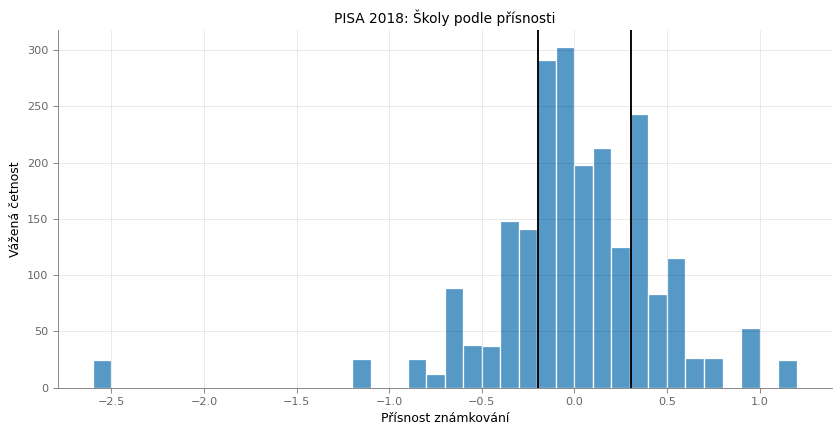

In [139]:
fig, ax = plt.subplots()
bins = np.arange(-2.6, 1.3, step=0.1)
sns.histplot(x='prisnost', weights='W_SCHGRNRABWT', data=sch_resid, bins=bins, edgecolor='white')
ax.axvline(qs[0.25], color='black', lw=1.5)
ax.axvline(qs[0.75], color='black', lw=1.5)
ax.set(xlabel='Přísnost známkování', ylabel='Vážená četnost', title='PISA 2018: Školy podle přísnosti')

In [ ]:
# měla by smysl relativní četnost?

/mnt/d/projects/idea/code/venv/lib/python3.10/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


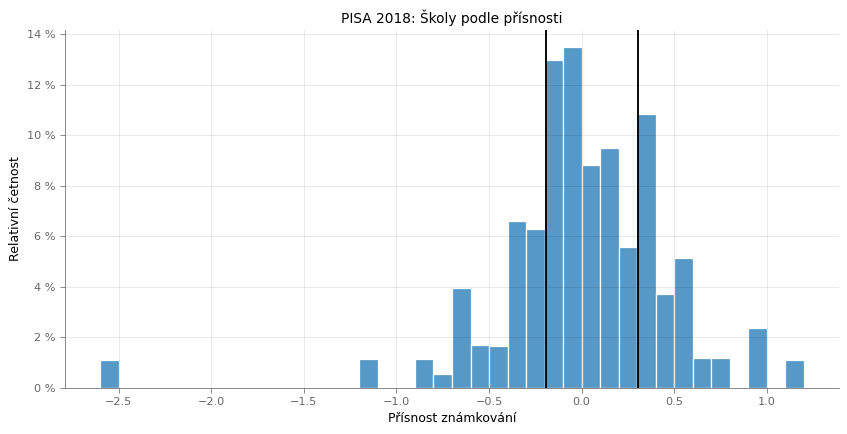

In [65]:
fig, ax = plt.subplots()
bins = np.arange(-2.6, 1.3, step=0.1)
sns.histplot(x='prisnost', weights='W_SCHGRNRABWT', data=sch_resid, bins=bins, edgecolor='white', stat='percent')
ax.axvline(qs[0.25], color='black', lw=1.5)
ax.axvline(qs[0.75], color='black', lw=1.5)
ax.set(xlabel='Přísnost známkování', ylabel='Relativní četnost', title='PISA 2018: Školy podle přísnosti')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))

In [66]:
fig.savefig('output/prisnost-znamkovani/05-rozlozeni-prisnosti.png')
fig.savefig('output/prisnost-znamkovani/05-rozlozeni-prisnosti.pdf')

In [46]:
sch_resid.head()

,CNTSCHID,prisnost,W_SCHGRNRABWT,prisnost_bin
0,20300002,0.374923,24.29682,2.0
1,20300005,-0.003525,26.19107,1.0
2,20300006,-0.367006,21.93036,0.0
3,20300010,0.014609,22.01021,1.0
4,20300018,0.192193,15.37976,1.0


In [45]:
foo = sch_resid.copy()

In [47]:
foo['fbin'] = pd.cut(foo['prisnost'], bins)

In [50]:
foo.groupby('fbin')['W_SCHGRNRABWT'].sum().reset_index()

,fbin,W_SCHGRNRABWT
0,"(-2.6, -2.5]",24.85357
1,"(-2.5, -2.4]",0.00000
2,"(-2.4, -2.3]",0.00000
3,"(-2.3, -2.2]",0.00000
4,"(-2.2, -2.1]",0.00000
5,"(-2.1, -2.0]",0.00000
6,"(-2.0, -1.9]",0.00000
7,"(-1.9, -1.8]",0.00000
8,"(-1.8, -1.7]",0.00000
9,"(-1.7, -1.6]",0.00000


In [51]:
qs[0.25], qs[0.75]

(-0.19437882843556595, 0.30710546381145887)

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'PISA 2018: Průměrné testové skóry z matematiky podle známek a přísnosti škol')]

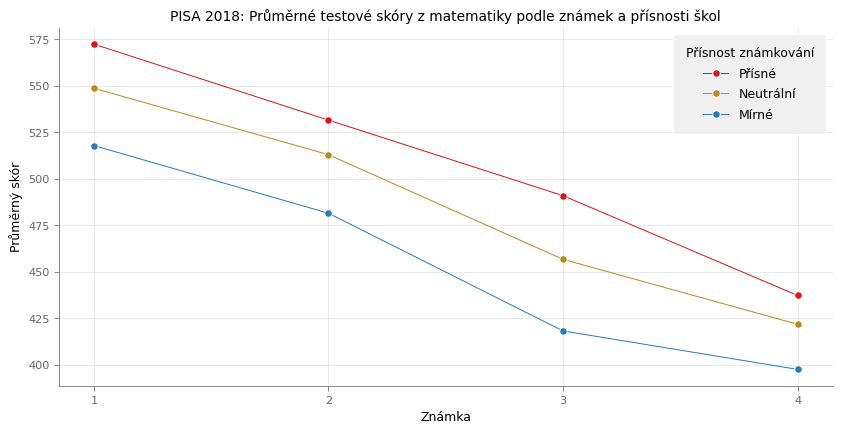

In [142]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
prisnost_pal = ['#d7191c', '#bb8822', '#2c7bb6']
prisnost_order = [2, 1, 0]

foo = df.groupby(['gr_matematika', 'prisnost_bin'])[['MATH_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['prisnost_group'] = pd.Categorical(foo['prisnost_bin'])
foo = foo[foo['gr_matematika'] != 5]
foo['gr_matematika'] = foo['gr_matematika'].apply(lambda x: f'{x:.0g}')
ax = sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='PISA 2018: Průměrné testové skóry z matematiky podle známek a přísnosti škol')

In [53]:
ax.get_figure().savefig('output/prisnost-znamkovani/07-skory-podle-znamek-a-prisnosti.png')
ax.get_figure().savefig('output/prisnost-znamkovani/07-skory-podle-znamek-a-prisnosti.pdf')

In [54]:
foo

,gr_matematika,prisnost_bin,MATH_MEAN,ST225Q06HA,BSMJ,prisnost_group
0,1,0.0,517.847480,0.818617,68.389373,0.0
1,1,1.0,548.675688,0.898093,68.777301,1.0
2,1,2.0,572.416277,0.878963,72.134947,2.0
3,2,0.0,481.452338,0.656817,60.529657,0.0
4,2,1.0,512.950412,0.720050,60.092377,1.0
5,2,2.0,531.545667,0.693899,60.247187,2.0
6,3,0.0,418.140817,0.349022,46.725472,0.0
7,3,1.0,456.646316,0.393255,48.269063,1.0
8,3,2.0,490.902845,0.456727,50.315854,2.0
9,4,0.0,397.453832,0.143811,39.460080,0.0


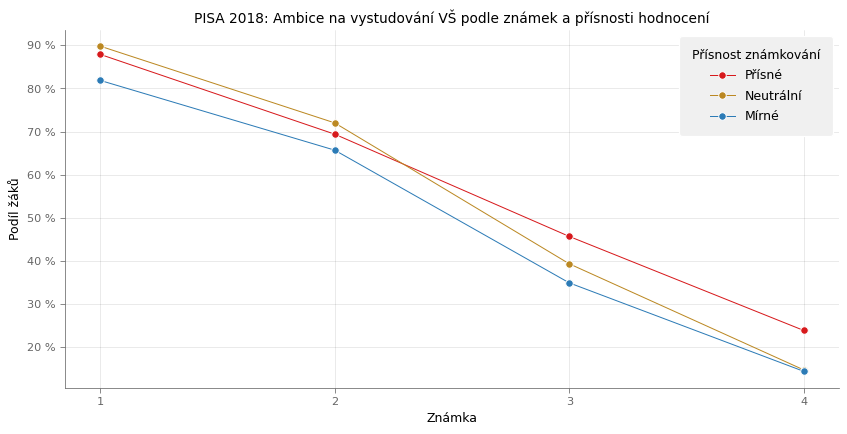

In [143]:
foo['ST225Q06HAx100'] = 100 * foo['ST225Q06HA']
ax = sns.lineplot(x='gr_matematika', y='ST225Q06HAx100', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(title='PISA 2018: Ambice na vystudování VŠ podle známek a přísnosti hodnocení', xlabel='Známka', ylabel='Podíl žáků')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))

In [56]:
ax.get_figure().savefig('output/prisnost-znamkovani/10-ambice-vs-znamky-prisnost.png')
ax.get_figure().savefig('output/prisnost-znamkovani/10-ambice-vs-znamky-prisnost.pdf')

### Model pro hlášení se na VŠ

In [75]:
df['ESCSz'].mean()  # ok, odstranil jsem nějaké missing values after standardization

-0.0013372014370761345

In [76]:
%stata gen ESCS_high = ESCSz > 0

In [77]:
%stata mi estimate, dots: logit ST225Q06HA mathz ib1.prisnost_bin ESCS_high girl [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.1020
                                                Largest FMI       =     0.2803
DF adjustment:   Large sample                   DF:     min       =     124.53
                                                        avg       =   8,779.89
                                                        max       =  25,855.48
Model F test:       Equal FMI                   F(   5, 3394.9)   =      55.13
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [78]:
er = stata.get_ereturn()

In [79]:
coefs = er['e(b_mi)'][0]
coefs

array([ 1.00946743,  0.45227233,  0.        , -0.3275284 ,  1.04934179,
        1.03098913, -0.81690456])

In [80]:
foo = pd.merge(pd.Series([0, 1], name='high_ses'), pd.Series([0, 1], name='girl'), how='cross')

foo['gender'] = np.where(foo['girl'], 'Dívka', 'Chlapec')
foo['label'] = foo.apply(lambda x: ('Dívka, ' if x['girl'] else 'Chlapec, ') + ('vysoký SES' if x['high_ses'] else 'nízký ses'), axis=1)

foo['logit_g1'] = coefs[6] + foo['girl'] * coefs[5] + foo['high_ses'] * coefs[4]
foo['logit_g0'] = foo['logit_g1'] + coefs[1]
foo['logit_g2'] = foo['logit_g1'] + coefs[3]

foo['prob_g1'] = logistic(foo['logit_g1']) * 100
foo['prob_g0'] = logistic(foo['logit_g0']) * 100
foo['prob_g2'] = logistic(foo['logit_g2']) * 100

foo = foo[::-1].reset_index(drop=True)

In [81]:
foo

,high_ses,girl,gender,label,logit_g1,logit_g0,logit_g2,prob_g1,prob_g0,prob_g2
0,1,1,Dívka,"Dívka, vysoký SES",1.263426,1.715699,0.935898,77.961537,84.757397,71.827032
1,1,0,Chlapec,"Chlapec, vysoký SES",0.232437,0.684710,-0.095091,55.784909,66.478901,47.624510
2,0,1,Dívka,"Dívka, nízký ses",0.214085,0.666357,-0.113444,55.331766,66.068693,47.166942
3,0,0,Chlapec,"Chlapec, nízký ses",-0.816905,-0.364632,-1.144433,30.642113,40.983870,24.150739


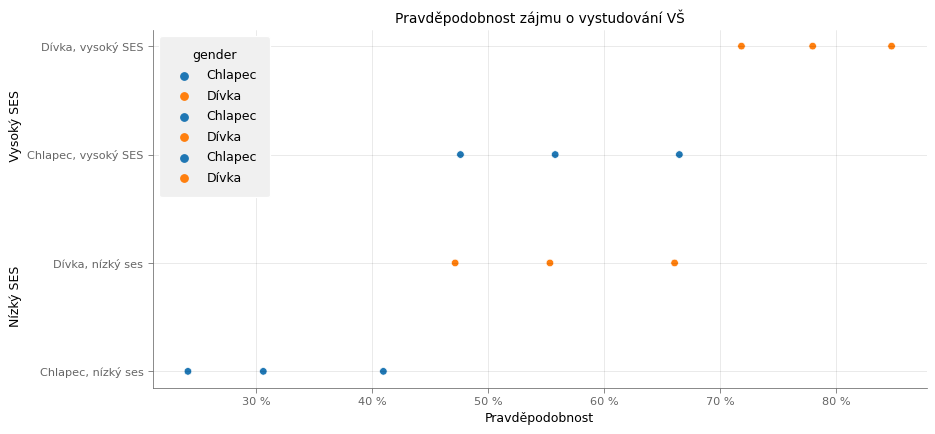

In [326]:
# cur_palette = sns.color_palette(n_colors=2)

fig, ax = plt.subplots()
sns.scatterplot(data=foo, y='label', x='prob_g1', hue='gender', hue_order=['Chlapec', 'Dívka'])
sns.scatterplot(data=foo, y='label', x='prob_g0', hue='gender', hue_order=['Chlapec', 'Dívka'])
sns.scatterplot(data=foo, y='label', x='prob_g2', hue='gender', hue_order=['Chlapec', 'Dívka'])

ax.set(xlabel='Pravděpodobnost', ylabel='', title='Pravděpodobnost zájmu o vystudování VŠ')  # , xlim=(0, 100))
ax.set(ylabel='Nízký SES                          Vysoký SES')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))

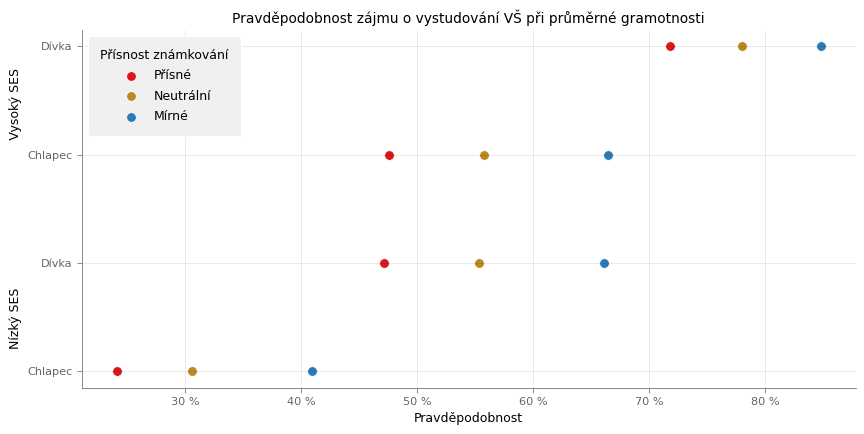

In [367]:
# cur_palette = sns.color_palette(n_colors=2)

fig, ax = plt.subplots()
sns.scatterplot(data=foo, y='label', x='prob_g2', color=prisnost_pal[0], label='Přísné', s=60)
sns.scatterplot(data=foo, y='label', x='prob_g1', color=prisnost_pal[1], label='Neutrální', s=60)
sns.scatterplot(data=foo, y='label', x='prob_g0', color=prisnost_pal[2], label='Mírné', s=60)

ax.set(xlabel='Pravděpodobnost', ylabel='', title='Pravděpodobnost zájmu o vystudování VŠ při průměrné gramotnosti')  # , xlim=(0, 100))
ax.set(ylabel='Nízký SES                                     Vysoký SES')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
plt.yticks([0, 1, 2, 3], 2 * ['Dívka', 'Chlapec'])
plt.legend(title='Přísnost známkování')

In [368]:
ax.get_figure().savefig('output/prisnost-znamkovani/12b-vs-ambice-prisnost.png')
ax.get_figure().savefig('output/prisnost-znamkovani/12b-vs-ambice-prisnost.pdf')

In [83]:
prisnost_pal = ['#d7191c', '#bb8822', '#2c7bb6']
prisnost_order = [2, 1, 0]

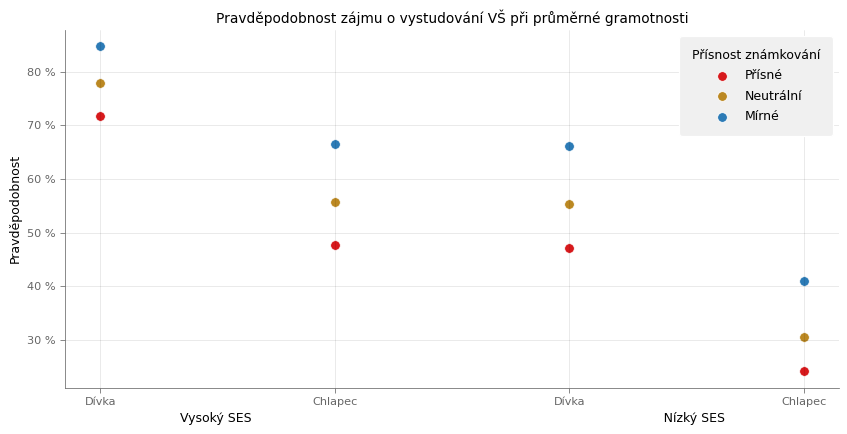

In [93]:
# cur_palette = sns.color_palette(n_colors=2)

fig, ax = plt.subplots()
sns.scatterplot(data=foo, x='label', y='prob_g2', color=prisnost_pal[0], label='Přísné', s=60)
sns.scatterplot(data=foo, x='label', y='prob_g1', color=prisnost_pal[1], label='Neutrální', s=60)
sns.scatterplot(data=foo, x='label', y='prob_g0', color=prisnost_pal[2], label='Mírné', s=60)

ax.set(ylabel='Pravděpodobnost', xlabel='', title='Pravděpodobnost zájmu o vystudování VŠ při průměrné gramotnosti')  # , xlim=(0, 100))
ax.set(xlabel='Vysoký SES                                                                                                       Nízký SES')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
plt.xticks([0, 1, 2, 3], 2 * ['Dívka', 'Chlapec'])
plt.legend(title='Přísnost známkování')

In [94]:
ax.get_figure().savefig('output/prisnost-znamkovani/12b-vs-ambice-prisnost-otoceny.png')
ax.get_figure().savefig('output/prisnost-znamkovani/12b-vs-ambice-prisnost-otoceny.pdf')

In [351]:
foo

,high_ses,girl,gender,label,logit_g1,logit_g0,logit_g2,prob_g1,prob_g0,prob_g2
0,1,1,Dívka,"Dívka, vysoký SES",1.263426,1.715699,0.935898,77.961537,84.757397,71.827032
1,1,0,Chlapec,"Chlapec, vysoký SES",0.232437,0.684710,-0.095091,55.784909,66.478901,47.624510
2,0,1,Dívka,"Dívka, nízký ses",0.214085,0.666357,-0.113444,55.331766,66.068693,47.166942
3,0,0,Chlapec,"Chlapec, nízký ses",-0.816905,-0.364632,-1.144433,30.642113,40.983870,24.150739


In [369]:
%stata mi estimate, dots: reg BSMJ mathz ib1.prisnost_bin ESCS_high girl [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,481
                                                Average RVI       =     0.0551
                                                Largest FMI       =     0.1453
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      87.34
                                                        avg       =     113.78
                                                        max       =     123.16
Model F test:       Equal FMI                   F(   5,  123.2)   =      84.45
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
        BSMJ

In [370]:
er = stata.get_ereturn()

In [371]:
coefs = er['e(b_mi)'][0]
coefs

array([ 7.27217141,  5.31590674,  0.        , -2.25366778,  8.68290317,
       10.41549389, 44.11354933])

In [372]:
foo = pd.merge(pd.Series([0, 1], name='high_ses'), pd.Series([0, 1], name='girl'), how='cross')

foo['gender'] = np.where(foo['girl'], 'Dívka', 'Chlapec')
foo['label'] = foo.apply(lambda x: ('Dívka, ' if x['girl'] else 'Chlapec, ') + ('vysoký SES' if x['high_ses'] else 'nízký ses'), axis=1)

foo['bsmj_g1'] = coefs[6] + foo['girl'] * coefs[5] + foo['high_ses'] * coefs[4]
foo['bsmj_g0'] = foo['bsmj_g1'] + coefs[1]
foo['bsmj_g2'] = foo['bsmj_g1'] + coefs[3]

foo = foo[::-1].reset_index(drop=True)

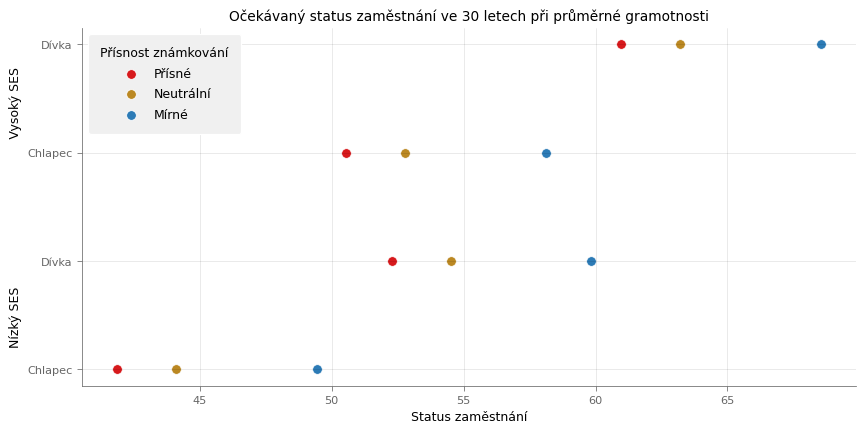

In [373]:
# cur_palette = sns.color_palette(n_colors=2)

fig, ax = plt.subplots()
sns.scatterplot(data=foo, y='label', x='bsmj_g2', color=prisnost_pal[0], label='Přísné', s=60)
sns.scatterplot(data=foo, y='label', x='bsmj_g1', color=prisnost_pal[1], label='Neutrální', s=60)
sns.scatterplot(data=foo, y='label', x='bsmj_g0', color=prisnost_pal[2], label='Mírné', s=60)

ax.set(xlabel='Status zaměstnání', ylabel='', title='Očekávaný status zaměstnání ve 30 letech při průměrné gramotnosti')  # , xlim=(0, 100))
ax.set(ylabel='Nízký SES                                     Vysoký SES')
plt.yticks([0, 1, 2, 3], 2 * ['Dívka', 'Chlapec'])
plt.legend(title='Přísnost známkování')

In [374]:
ax.get_figure().savefig('output/prisnost-znamkovani/12c-ses-zamestnani-prisnost.png')
ax.get_figure().savefig('output/prisnost-znamkovani/12c-ses-zamestnani-prisnost.pdf')

In [375]:
foo

,high_ses,girl,gender,label,bsmj_g1,bsmj_g0,bsmj_g2
0,1,1,Dívka,"Dívka, vysoký SES",63.211946,68.527853,60.958279
1,1,0,Chlapec,"Chlapec, vysoký SES",52.796452,58.112359,50.542785
2,0,1,Dívka,"Dívka, nízký ses",54.529043,59.844950,52.275375
3,0,0,Chlapec,"Chlapec, nízký ses",44.113549,49.429456,41.859882


In [359]:
%stata mi estimate, dots: logit ST225Q06HA gr_matematika ESCS_high girl [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.0000
                                                Largest FMI       =     0.0000
DF adjustment:   Large sample                   DF:     min       =          .
                                                        avg       =          .
                                                        max       =          .
Model F test:       Equal FMI                   F(   3,      .)   =     127.46
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [285]:
nanaverage(df[['ESCSz', 'W_FSTUWT']], weights='W_FSTUWT')

ESCSz   -0.042346
dtype: float64

In [284]:
nanaverage(df[['MATH_Z', 'W_FSTUWT']], weights='W_FSTUWT')[0]

-0.025779706454713825

In [280]:
%stata mi estimate, dots: logit ST225Q06HA mathz ib1.prisnost_bin ESCSz girl [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.0933
                                                Largest FMI       =     0.2619
DF adjustment:   Large sample                   DF:     min       =     142.20
                                                        avg       =   8,728.71
                                                        max       =  34,289.90
Model F test:       Equal FMI                   F(   5, 4046.7)   =      61.09
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz

In [135]:
np.round([logistic(0.037 * 0.977 - 0.351 + 0.460), logistic(0.037 * 0.977 - 0.351), logistic(0.037 * 0.977 - 0.351 - 0.272)], 3)

array([0.536, 0.422, 0.357])

In [136]:
np.round([logistic(-0.096 * 0.977 - 0.351 + 1.051 + 0.460), logistic(-0.096 * 0.977 - 0.351 + 1.051), logistic(-0.096 * 0.977 - 0.351 + 1.051 - 0.272)], 3)

array([0.744, 0.647, 0.583])

In [134]:
%stata mi estimate, dots: reg mathz girl [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.3319
                                                Largest FMI       =     0.3817
                                                Complete DF       =       1869
DF adjustment:   Small sample                   DF:     min       =      64.44
                                                        avg       =     125.89
                                                        max       =     187.34
Model F test:       Equal FMI                   F(   1,   64.4)   =       4.72
Within VCE type:       Robust                   Prob > F          =     0.0335

------------------------------------------------------------------------------
       mathz | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

[Text(0.5, 1.0, 'Očekávaný socioekonomický status zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Status zaměstnání')]

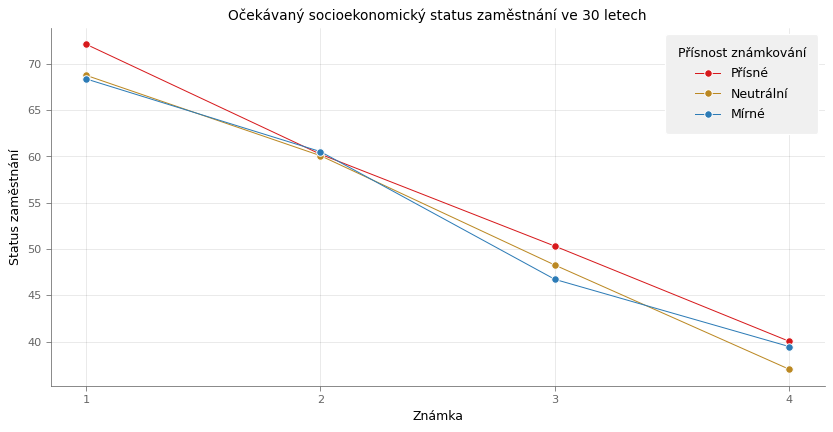

In [57]:
ax = sns.lineplot(x='gr_matematika', y='BSMJ', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(title='Očekávaný socioekonomický status zaměstnání ve 30 letech', xlabel='Známka', ylabel='Status zaměstnání')

In [58]:
ax.get_figure().savefig('output/prisnost-znamkovani/11-ses-zamestnani-vs-znamky-prisnost.png')
ax.get_figure().savefig('output/prisnost-znamkovani/11-ses-zamestnani-vs-znamky-prisnost.pdf')

In [59]:
foo

,gr_matematika,prisnost_bin,MATH_MEAN,ST225Q06HA,BSMJ,prisnost_group,ST225Q06HAx100
0,1,0.0,517.847480,0.818617,68.389373,0.0,81.861715
1,1,1.0,548.675688,0.898093,68.777301,1.0,89.809250
2,1,2.0,572.416277,0.878963,72.134947,2.0,87.896340
3,2,0.0,481.452338,0.656817,60.529657,0.0,65.681739
4,2,1.0,512.950412,0.720050,60.092377,1.0,72.004952
5,2,2.0,531.545667,0.693899,60.247187,2.0,69.389861
6,3,0.0,418.140817,0.349022,46.725472,0.0,34.902222
7,3,1.0,456.646316,0.393255,48.269063,1.0,39.325474
8,3,2.0,490.902845,0.456727,50.315854,2.0,45.672739
9,4,0.0,397.453832,0.143811,39.460080,0.0,14.381065


[Text(0.5, 0, 'Známka'), Text(0, 0.5, 'Relativní četnost')]

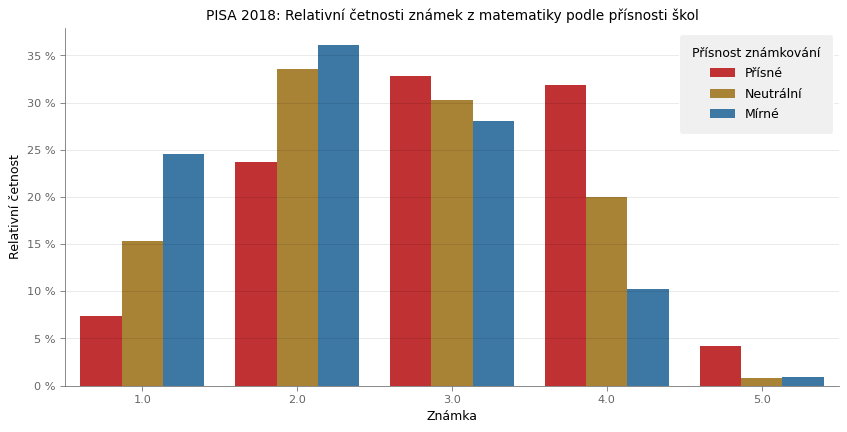

In [141]:
foo = df.groupby(['gr_matematika', 'prisnost_bin'])['W_FSTUWT'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('prisnost_bin')['W_FSTUWT'].sum().rename('W_FSTUWT_TOTAL').reset_index())
foo['prisnost_group'] = pd.Categorical(foo['prisnost_bin'])
foo['rel_weight'] = 100 * foo['W_FSTUWT'] / foo['W_FSTUWT_TOTAL']
ax = sns.barplot(x='gr_matematika', y='rel_weight', hue='prisnost_group', data=foo, palette=prisnost_pal, hue_order=prisnost_order)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set_title('PISA 2018: Relativní četnosti známek z matematiky podle přísnosti škol')
ax.set(xlabel='Známka', ylabel='Relativní četnost')

In [61]:
ax.get_figure().savefig('output/prisnost-znamkovani/06-cetnosti-znamek-podle-prisnosti.png')
ax.get_figure().savefig('output/prisnost-znamkovani/06-cetnosti-znamek-podle-prisnosti.pdf')

In [62]:
foo

,gr_matematika,prisnost_bin,W_FSTUWT,W_FSTUWT_TOTAL,prisnost_group,rel_weight
0,1.0,0.0,1911.69239,7773.25666,0.0,24.593198
1,2.0,0.0,2807.90492,7773.25666,0.0,36.122632
2,3.0,0.0,2180.27414,7773.25666,0.0,28.048400
3,4.0,0.0,799.33475,7773.25666,0.0,10.283139
4,5.0,0.0,74.05046,7773.25666,0.0,0.952631
5,1.0,1.0,2877.69266,18729.71621,1.0,15.364315
6,2.0,1.0,6278.84664,18729.71621,1.0,33.523448
7,3.0,1.0,5676.76828,18729.71621,1.0,30.308886
8,4.0,1.0,3751.03898,18729.71621,1.0,20.027207
9,5.0,1.0,145.36965,18729.71621,1.0,0.776144


In [63]:
%stata mi estimate, dots: reg math ibn.prisnost_bin [pw = W_FSTUWT], noconstant


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.3347
                                                Largest FMI       =     0.3928
                                                Complete DF       =       1868
DF adjustment:   Small sample                   DF:     min       =      61.03
                                                        avg       =     201.87
                                                        max       =     331.46
Model F test:       Equal FMI                   F(   3,  279.2)   =   14751.89
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [65]:
er = stata.get_ereturn()
coefs = er['e(b_mi)']
std_errs = np.sqrt(np.diag(er['e(V_mi)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

blbls = ['Mírné', 'Neutrální', 'Přísné']

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['prisnost_bin'] = foo.index
foo['label'] = foo['prisnost_bin'].apply(lambda x: blbls[int(x)])
foo = foo.sort_values('prisnost_bin', ascending=False).reset_index(drop=True)
foo

,coef,se,lc,uc,prisnost_bin,label
0,485.995394,6.218971,473.798531,498.192257,2,Přísné
1,482.443071,3.087357,476.388040,488.498102,1,Neutrální
2,462.820505,4.526388,453.943197,471.697814,0,Mírné


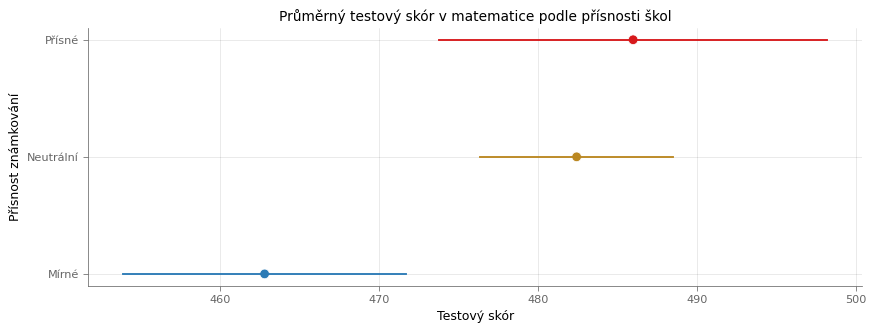

In [66]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='label', data=foo, hue='prisnost_bin', hue_order=[2, 1, 0], palette=prisnost_pal, legend=False, s=60)
for i in range(3):
    plt.plot(foo.loc[i, ['lc', 'uc']], [i, i], color=prisnost_pal[i], lw=1.5)
ax.set(xlabel='Testový skór', ylabel='Přísnost známkování', title='Průměrný testový skór v matematice podle přísnosti škol')
None

### Boxploty - skóry jednotlivých skupin

In [67]:
boxplots = []

bxp_def = {
    'med': 0.5,
    'q1': 0.25,
    'q3': 0.75,
    'whislo': 0.05,
    'whishi': 0.95
}

blbls = ['Mírné', 'Neutrální', 'Přísné']

for b, blbl in enumerate(blbls):
    print(f'running {b} -- {blbl}')
    inner = {}
    inner['label'] = blbl
    inner['fliers'] = []
    cmd = 'qreg math [pw = W_FSTUWT]'
    for lbl, q in bxp_def.items():        
        stata.run(f'''
            preserve
            keep if prisnost_bin == {b}
            mi estimate, dots: {cmd}, q({q})
            restore
        ''', quietly=True)
        inner[lbl] = stata.get_ereturn()['e(b_mi)'][0][0]
    boxplots.append(inner)

running 0 -- Mírné





running 1 -- Neutrální





running 2 -- Přísné







[Text(0.5, 0, 'Skór z matematiky'),
 Text(0, 0.5, 'Přísnost známkování'),
 Text(0.5, 1.0, 'Testové skóry podle přísnosti škol')]

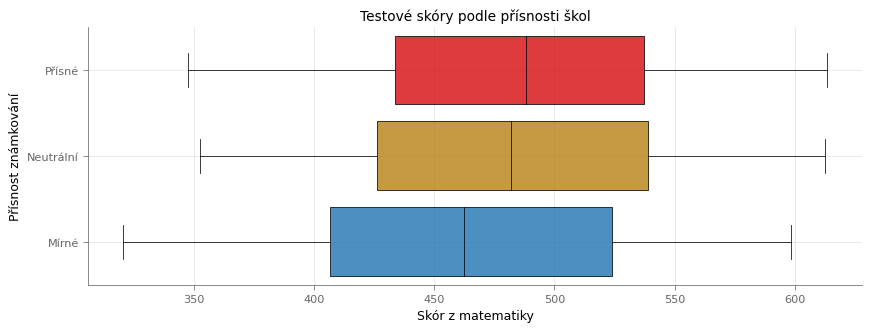

In [68]:
fig, ax = plt.subplots(figsize=(10, 3.6))

props = dict(linewidth=0.6, color='black')
pal = prisnost_pal[::-1]

boxes = ax.bxp(boxplots, vert=False, widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    col = tuple(int(pal[i][j:j+2], 16) / 255 for j in (1, 3, 5))
    bx.set_facecolor([*col, 0.85])
None

ax.set(xlabel='Skór z matematiky', ylabel='Přísnost známkování', title='Testové skóry podle přísnosti škol')

In [69]:
pd.DataFrame(boxplots).drop(columns=['fliers']).rename(columns={'label': 'prisnost'})

,prisnost,med,q1,q3,whislo,whishi
0,Mírné,462.535101,406.552200,523.992096,320.647800,598.668091
1,Neutrální,481.967999,426.102597,538.961700,352.366196,612.644501
2,Přísné,487.995700,433.504700,537.122504,347.647601,613.470905


### Boxploty pro aspirace podle přísnosti

In [70]:
def get_bx_data(frame, x, weights=None):
    if weights is not None:        
        dsw = DescrStatsW(frame[x], weights=frame[weights])
    else:
        dsw = DescrStatsW(frame[x])
    res = pd.Series({k: dsw.quantile(v).values[0] for k, v in bxp_def.items()})
    res['fliers'] = []
    return res

bx_bsmj = df.groupby('prisnost_bin').apply(lambda fr: get_bx_data(fr, 'BSMJ', weights='W_FSTUWT')).reset_index()
bx_bsmj['label'] = bx_bsmj['prisnost_bin'].apply(lambda x: blbls[int(x)])

In [71]:
bx_bsmj

,prisnost_bin,med,q1,q3,whislo,whishi,fliers,label
0,0.0,55.25,36.35,76.65,24.53,88.31,[],Mírné
1,1.0,51.50,31.08,74.66,23.57,86.72,[],Neutrální
2,2.0,47.42,30.78,73.71,24.53,83.50,[],Přísné


[Text(0.5, 0, 'BSMJ'),
 Text(0, 0.5, 'Přísnost známkování'),
 Text(0.5, 1.0, 'Očekávaná kvalifikace zaměstnání ve 30 letech')]

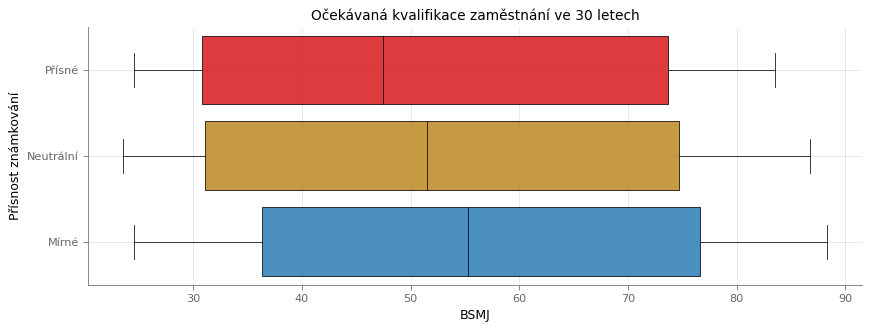

In [74]:
fig, ax = plt.subplots(figsize=(10, 3.6))

props = dict(linewidth=0.6, color='black')
pal = prisnost_pal[::-1]
bx_bsmj_data = [dict(r) for _, r in bx_bsmj.iterrows()]

boxes = ax.bxp(bx_bsmj_data, vert=False, widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    col = tuple(int(pal[i][j:j+2], 16) / 255 for j in (1, 3, 5))
    bx.set_facecolor([*col, 0.85])
None

ax.set(xlabel='BSMJ', ylabel='Přísnost známkování', title='Očekávaná kvalifikace zaměstnání ve 30 letech')

In [73]:
%stata reg BSMJ ibn.prisnost_bin [pw = W_FSTUWT], noconstant

(sum of wgt is 25,217.61132)

Linear regression                               Number of obs     =      1,481
                                                F(3, 1478)        =    2632.83
                                                Prob > F          =     0.0000
                                                R-squared         =     0.8549
                                                Root MSE          =     21.881

------------------------------------------------------------------------------
             |               Robust
        BSMJ | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
prisnost_bin |
          0  |    55.9091   1.172784    47.67   0.000      53.6086     58.2096
          1  |   52.68951   .7627074    69.08   0.000     51.19341    54.18562
          2  |   49.83751   1.705886    29.22   0.000     46.49129    53.18372
-------------------------------------------------

In [75]:
er = stata.get_ereturn()
coefs = er['e(b)']
std_errs = np.sqrt(np.diag(er['e(V)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

In [76]:
foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['prisnost_bin'] = foo.index
foo['label'] = foo['prisnost_bin'].apply(lambda x: blbls[int(x)])
foo = foo.sort_values('prisnost_bin', ascending=False).reset_index(drop=True)
foo

,coef,se,lc,uc,prisnost_bin,label
0,49.837506,1.705886,46.491291,53.183722,2,Přísné
1,52.689511,0.762707,51.193407,54.185615,1,Neutrální
2,55.909097,1.172784,53.608599,58.209596,0,Mírné


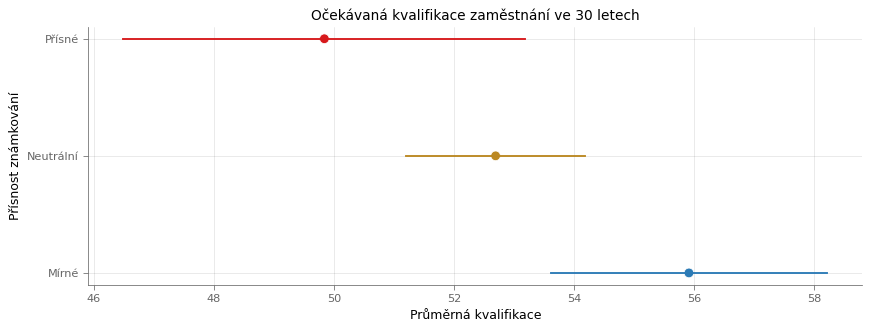

In [77]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='label', data=foo, hue='prisnost_bin', hue_order=[2, 1, 0], palette=prisnost_pal, legend=False, s=60)
for i in range(3):
    plt.plot(foo.loc[i, ['lc', 'uc']], [i, i], color=prisnost_pal[i], lw=1.5)
ax.set(xlabel='Průměrná kvalifikace', ylabel='Přísnost známkování', title='Očekávaná kvalifikace zaměstnání ve 30 letech')
None

In [ ]:
%stata logit ST225Q06HA ibn.prisnost_bin [pw = W_FSTUWT], noconstant

In [ ]:
er = stata.get_ereturn()
coefs = er['e(b)']
std_errs = np.sqrt(np.diag(er['e(V)']))

In [81]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

In [ ]:
foo['prob'] = logistic(foo['coef']) * 100
foo['lp'] = logistic(foo['coef'] + scipy.stats.norm.ppf(0.025) * foo['se']) * 100
foo['up'] = logistic(foo['coef'] + scipy.stats.norm.ppf(0.975) * foo['se']) * 100

In [ ]:
foo['prisnost_bin'] = foo.index
foo['label'] = foo['prisnost_bin'].apply(lambda x: blbls[int(x)])

In [ ]:
foo = foo.sort_values('prisnost_bin', ascending=False).reset_index(drop=True)
foo

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='prob', y='label', data=foo, hue='prisnost_bin', hue_order=[2, 1, 0], palette=prisnost_pal, legend=False, s=60)
for i in range(3):
    plt.plot(foo.loc[i, ['lp', 'up']], [i, i], color=prisnost_pal[i], lw=1.5)
ax.set(xlabel='Pravděpodobnost', ylabel='Přísnost známkování', title='Pravděpodobnost vystudování VŠ')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
None

In [ ]:
df.groupby('prisnost_bin')[['ST225Q06HA', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')

In [94]:
%stata mi estimate, dots: reg mathz [pw = W_FSTUWT]
mathz_mean = stata.get_ereturn()['e(b_mi)'][0][0]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.0870
                                                Largest FMI       =     0.0814
                                                Complete DF       =       1870
                                                DF:     min       =     773.16
                                                        avg       =     773.16
DF adjustment:   Small sample                           max       =     773.16
                                                F(   0,      .)   =          .
Within VCE type:       Robust                   Prob > F          =          .

------------------------------------------------------------------------------
       mathz | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

In [ ]:
%stata mi estimate, dots: logit ST225Q06HA mathz ib1.prisnost_bin [pw = W_FSTUWT]
coefs = stata.get_ereturn()['e(b_mi)'][0]

In [ ]:
coefs

In [ ]:
# žáci z neutrálně známkujících škol s průměrným skórem (průměr je celkový)
logistic(coefs[4] + coefs[0] * mathz_mean)

In [ ]:
# žáci z mírných škol s průměrným skórem 
logistic(coefs[4] + coefs[0] * mathz_mean + coefs[1])

In [ ]:
# žáci z přísných škol s průměrným skórem 
logistic(coefs[4] + coefs[0] * mathz_mean + coefs[3])

In [ ]:
%stata mi estimate, dots: reg math [pw = W_FSTUWT]

In [ ]:
mathz_mean

In [ ]:
%stata logit ST225Q06HA [pw = W_FSTUWT]

In [ ]:
logistic(stata.get_ereturn()['e(b)'][0][0])

In [ ]:
nanaverage(df[['ST225Q06HA', 'W_FSTUWT']], weights='W_FSTUWT')

In [ ]:
%stata mi estimate, dots: logit ST225Q06HA mathz girl ESCSz [pw = W_FSTUWT]

In [89]:
%stata gen ESCSz_pos = ESCSz > 0

In [90]:
%stata mi estimate, dots: logit ST225Q06HA mathz girl ESCSz_pos [pw = W_FSTUWT]
coefs = stata.get_ereturn()['e(b_mi)'][0]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.1245
                                                Largest FMI       =     0.2619
DF adjustment:   Large sample                   DF:     min       =     142.17
                                                        avg       =   4,103.97
                                                        max       =   9,467.82
Model F test:       Equal FMI                   F(   3, 1056.4)   =      94.67
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz

In [91]:
coefs

array([ 0.96583163,  1.00896179,  1.05412871, -0.75675765])

In [95]:
# chlapec, nízký SES
boy_low = logistic(coefs[3] + mathz_mean * coefs[0])
boy_low

0.31474227039762487

In [96]:
# dívka, nízký SES
girl_low = logistic(coefs[3] + mathz_mean * coefs[0] + coefs[1])
girl_low

0.5574750471256797

In [97]:
# chlapec, vysoký SES
boy_high = logistic(coefs[3] + mathz_mean * coefs[0] + coefs[2])
boy_high

0.5685868373538834

In [98]:
# dívka, vysoký SES
girl_high = logistic(coefs[3] + mathz_mean * coefs[0] + coefs[1] + coefs[2])
girl_high

0.7833081032638246

In [99]:
foo = pd.DataFrame({'ses': 2 * ['Nízký SES', 'Vysoký SES'], 'gender': 2 * ['Chlapec'] + 2 * ['Dívka'], 'uni': [boy_low, boy_high, girl_low, girl_high]})
foo['unix100'] = 100 * foo['uni']

[Text(0.5, 0, 'Pravděpodobnost'),
 Text(0, 0.5, 'Socioekonomický status'),
 Text(0.5, 1.0, 'Pravděpodobnost, že žák s průměrnou gramotností chce vystudovat VŠ')]

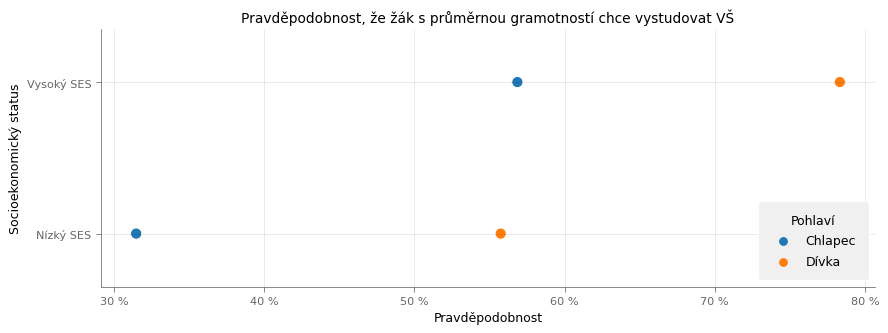

In [100]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='unix100', y='ses', data=foo, hue='gender', s=80)
ymax, ymin = ax.get_ylim()
ax.set_ylim((ymin - 0.3, ymax + 0.3))
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
plt.legend(loc='lower right', title='Pohlaví')
ax.set(xlabel='Pravděpodobnost', ylabel='Socioekonomický status', title='Pravděpodobnost, že žák s průměrnou gramotností chce vystudovat VŠ')

In [101]:
ax.get_figure().savefig('output/prisnost-znamkovani/12-ambice-vs-logit-gender-ses.png')
ax.get_figure().savefig('output/prisnost-znamkovani/12-ambice-vs-logit-gender-ses.pdf')

In [102]:
foo

,ses,gender,uni,unix100
0,Nízký SES,Chlapec,0.314742,31.474227
1,Vysoký SES,Chlapec,0.568587,56.858684
2,Nízký SES,Dívka,0.557475,55.747505
3,Vysoký SES,Dívka,0.783308,78.330810


In [ ]:
%stata mi estimate, dots: logit ST225Q06HA mathz girl ESCSz_pos ib2.gr_matematika [pw = W_FSTUWT]

In [ ]:
2 * [0, 1]

In [ ]:
logistic()

In [ ]:
%stata gen ESCSz_pos = ESCSz > 0

In [ ]:
%stata tab ESCSz_pos

### Známky vs vzdělávací a kariérní aspirace

In [67]:
%stata logit ST225Q06HA ibn.gr_matematika [pw = W_FSTUWT], noconstant


Iteration 0:   log pseudolikelihood = -21926.592  
Iteration 1:   log pseudolikelihood = -17670.453  
Iteration 2:   log pseudolikelihood = -17633.878  
Iteration 3:   log pseudolikelihood = -17633.329  
Iteration 4:   log pseudolikelihood = -17633.326  
Iteration 5:   log pseudolikelihood = -17633.326  

Logistic regression                                     Number of obs =  1,871
                                                        Wald chi2(5)  = 325.03
Log pseudolikelihood = -17633.326                       Prob > chi2   = 0.0000

------------------------------------------------------------------------------
             |               Robust
  ST225Q06HA | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a |
          1  |   1.877243   .1762571    10.65   0.000     1.531786    2.222701
          2  |   .8460131   .0970277     8.72   0.000     .6558423    1.036184
        

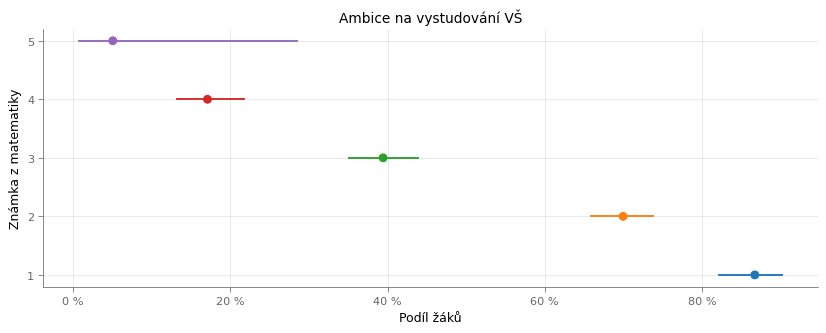

In [68]:
er = stata.get_ereturn()
coefs = er['e(b)']
std_errs = np.sqrt(np.diag(er['e(V)']))

foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})
foo['prob'] = logistic(foo['coef']) * 100
foo['lp'] = logistic(foo['coef'] + scipy.stats.norm.ppf(0.025) * foo['se']) * 100
foo['up'] = logistic(foo['coef'] + scipy.stats.norm.ppf(0.975) * foo['se']) * 100

foo['gr_matematika'] = foo.index + 1

cur_palette = sns.color_palette(n_colors=5)

fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='prob', y='gr_matematika', data=foo, hue='gr_matematika', legend=False, s=60, palette=cur_palette)
for i in range(5):
    plt.plot(foo.loc[i, ['lp', 'up']], [i + 1, i + 1], color=cur_palette[i], lw=1.5)
ax.set(xlabel='Podíl žáků', ylabel='Známka z matematiky', title='Ambice na vystudování VŠ')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))
None

In [ ]:
ax.get_figure().savefig('output/prisnost-znamkovani/08-ambice-vs-znamky.png')
ax.get_figure().savefig('output/prisnost-znamkovani/08-ambice-vs-znamky.pdf')

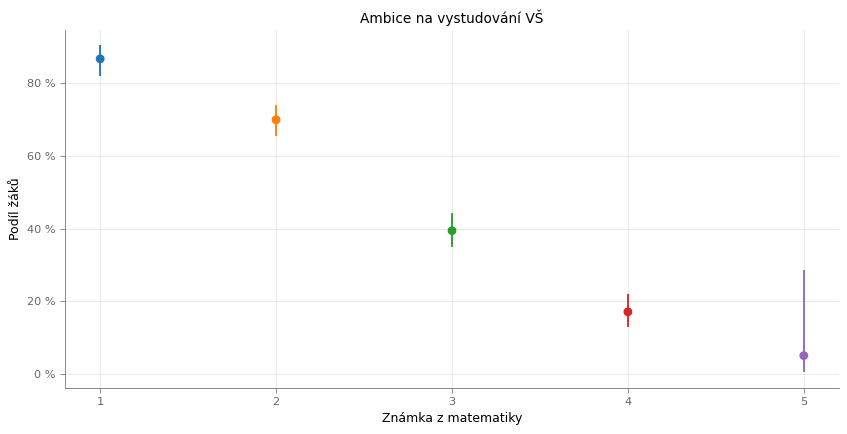

In [69]:
fig, ax = plt.subplots()
sns.scatterplot(x='gr_matematika', y='prob', data=foo, hue='gr_matematika', legend=False, s=60, palette=cur_palette)
for i in range(5):
    plt.plot([i + 1, i + 1], foo.loc[i, ['lp', 'up']], color=cur_palette[i], lw=1.5)
ax.set(xlabel='Známka z matematiky', ylabel='Podíl žáků', title='Ambice na vystudování VŠ')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
None

In [70]:
ax.get_figure().savefig('output/prisnost-znamkovani/08-ambice-vs-znamky-otoceny.png')
ax.get_figure().savefig('output/prisnost-znamkovani/08-ambice-vs-znamky-otoceny.pdf')

In [84]:
foo

,coef,se,prob,lp,up,gr_matematika
0,1.877243,0.176257,86.729418,82.226746,90.226962,1
1,0.846013,0.097028,69.973014,65.832580,73.811303,2
2,-0.429079,0.094306,39.434628,35.116637,43.924129,3
3,-1.579311,0.152892,17.089304,13.250668,21.761017,4
4,-2.935317,1.027344,5.043510,0.704146,28.459945,5


In [71]:
%stata reg BSMJ ibn.gr_matematika [pw = W_FSTUWT], noconstant

(sum of wgt is 25,217.61132)

Linear regression                               Number of obs     =      1,481
                                                F(5, 1476)        =    2008.09
                                                Prob > F          =     0.0000
                                                R-squared         =     0.8877
                                                Root MSE          =     19.261

------------------------------------------------------------------------------
             |               Robust
        BSMJ | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a |
          1  |   68.90215   1.312535    52.50   0.000     66.32752    71.47678
          2  |   60.23293   .9914795    60.75   0.000     58.28807    62.17779
          3  |   48.26596   1.036237    46.58   0.000      46.2333    50.29861
          4  |    38.1224   1.031228    36.97   0

In [72]:
er = stata.get_ereturn()
coefs = er['e(b)']
std_errs = np.sqrt(np.diag(er['e(V)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['gr_matematika'] = foo.index + 1
foo

,coef,se,lc,uc,gr_matematika
0,68.902151,1.312535,66.327519,71.476783,1
1,60.232932,0.991479,58.288073,62.177791,2
2,48.265955,1.036237,46.233301,50.298609,3
3,38.122396,1.031228,36.099567,40.145225,4
4,38.186225,5.019542,28.340029,48.032421,5


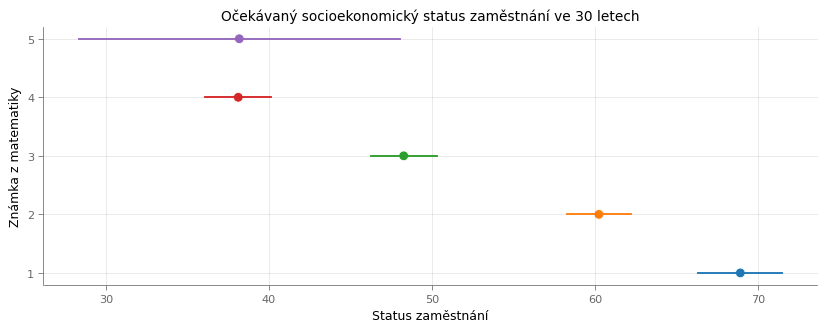

In [87]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='gr_matematika', data=foo, hue='gr_matematika', palette=cur_palette, legend=False, s=60)
for i in range(5):
    plt.plot(foo.loc[i, ['lc', 'uc']], [i + 1, i + 1], color=cur_palette[i], lw=1.5)
ax.set(xlabel='Status zaměstnání', ylabel='Známka z matematiky', title='Očekávaný socioekonomický status zaměstnání ve 30 letech')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))
None

In [ ]:
ax.get_figure().savefig('output/prisnost-znamkovani/09-ses-zamestnani-vs-znamky.png')
ax.get_figure().savefig('output/prisnost-znamkovani/09-ses-zamestnani-vs-znamky.pdf')

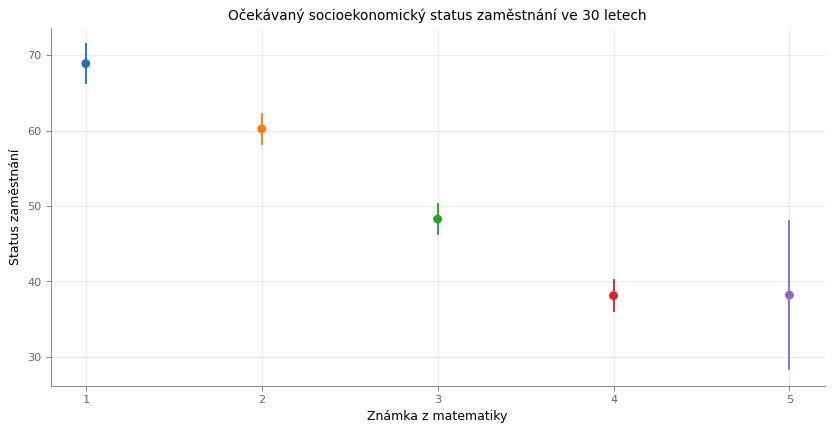

In [73]:
fig, ax = plt.subplots()
sns.scatterplot(x='gr_matematika', y='coef', data=foo, hue='gr_matematika', palette=cur_palette, legend=False, s=60)
for i in range(5):
    plt.plot([i + 1, i + 1], foo.loc[i, ['lc', 'uc']], color=cur_palette[i], lw=1.5)
ax.set(xlabel='Známka z matematiky', ylabel='Status zaměstnání', title='Očekávaný socioekonomický status zaměstnání ve 30 letech')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))
None

In [74]:
ax.get_figure().savefig('output/prisnost-znamkovani/09-ses-zamestnani-vs-znamky-otoceny.png')
ax.get_figure().savefig('output/prisnost-znamkovani/09-ses-zamestnani-vs-znamky-otoceny.pdf')

In [88]:
foo

,coef,se,lc,uc,gr_matematika
0,68.902151,1.312535,66.327519,71.476783,1
1,60.232932,0.991479,58.288073,62.177791,2
2,48.265955,1.036237,46.233301,50.298609,3
3,38.122396,1.031228,36.099567,40.145225,4
4,38.186225,5.019542,28.340029,48.032421,5


### Logit model pro vystudování VŠ nebo regrese pro SBMJ

Testové skóry hrají roli, ale známky jsou důležitější.

In [ ]:
%%stata
gen gr_cestina = ST800C02HA_CZ
gen gr_anglictina = ST800C03HA_CZ
gen gr_fyzika = ST800C04HA_CZ

recode gr_cestina 6=.
recode gr_anglictina 6=.
recode gr_fyzika 6=.

egen gr_cestina_z = std(gr_cestina)
egen gr_anglictina_z = std(gr_anglictina)
egen gr_fyzika_z = std(gr_fyzika)

In [ ]:
%stata mi estimate, dots: logit ST225Q06HA gr_matematika_z gr_cestina_z gr_anglictina_z gr_fyzika_z mathz girl ESCSz [pw = W_FSTUWT]

In [ ]:
%stata mi estimate, dots: logit ST225Q06HA gr_matematika_z mathz girl ESCSz [pw = W_FSTUWT]

In [ ]:
%stata mi estimate, dots: reg BSMJ gr_matematika_z mathz girl ESCSz [pw = W_FSTUWT]

In [145]:
df.columns

Index(['CNTSTUID', 'CNTSCHID', 'CNTRYID', 'STRATUM', 'STRATUMID_rec',
       'ST001D01T', 'ST003D02T', 'ST003D03T', 'ST004D01T', 'ST005Q01TA',
       ...
       'PV7MATHz', 'PV8MATHz', 'PV9MATHz', 'PV10MATHz', 'MATH_MEAN', 'MATH_Z',
       'gr_matematika_pred', 'gr_matematika_resid', 'prisnost',
       'prisnost_bin'],
      dtype='object', length=769)

In [144]:
df.shape

(1871, 769)

### Dekompozice rozptylu pro jednotlivé úrovně

In [146]:
df.shape

(1871, 769)

In [147]:
df.head()

,CNTSTUID,CNTSCHID,CNTRYID,STRATUM,STRATUMID_rec,ST001D01T,ST003D02T,ST003D03T,ST004D01T,ST005Q01TA,...,PV7MATHz,PV8MATHz,PV9MATHz,PV10MATHz,MATH_MEAN,MATH_Z,gr_matematika_pred,gr_matematika_resid,prisnost,prisnost_bin
0,20304622,20300002,203,CZE0606,1,9,5,2002,2,2.0,...,0.189223,-0.730399,-1.141469,-0.975003,445.2203,-0.427784,2.867802,0.132198,0.374923,2.0
1,20307274,20300002,203,CZE0606,1,9,12,2002,1,2.0,...,-0.809895,0.496858,-0.497336,-0.640061,459.8332,-0.253092,2.562328,0.437672,0.374923,2.0
2,20300029,20300002,203,CZE0606,1,9,6,2002,2,1.0,...,-1.278672,-0.928984,0.030315,-1.934317,402.2663,-0.958742,3.220790,-1.220790,0.374923,2.0
3,20301624,20300002,203,CZE0606,1,9,2,2002,2,2.0,...,-0.919837,-2.485988,-1.642863,-1.068422,366.0841,-1.398029,3.534842,1.465158,0.374923,2.0
4,20300521,20300002,203,CZE0606,1,9,10,2002,1,1.0,...,0.624678,-0.378370,-0.203900,-0.029818,489.2633,0.112894,2.062016,-1.062016,0.374923,2.0


In [163]:
# within students: sum of (PVs - MATH_MEAN) ^ 2, to celé * W_FSTUWT (/ 10 ? -> asi ano, ať se s tím faktorem * 10 potom nemusím drbat)
ss_pvs = np.sum(np.mean((df[[f'PV{i}MATH' for i in range(1, 11)]].values - df[['MATH_MEAN']].values) ** 2, axis=1) * df['W_FSTUWT'].values)
ss_pvs

33881729.094982155

In [169]:
grand_mean = nanaverage(df[['MATH_MEAN', 'W_FSTUWT']], weights='W_FSTUWT')[0]
grand_mean

478.19735538298977

In [172]:
# total sum of squares, including variance in plausible values
ss_total = np.sum(np.mean((df[[f'PV{i}MATH' for i in range(1, 11)]].values - grand_mean) ** 2, axis=1) * df['W_FSTUWT'].values)
ss_total

209298227.62687236

In [181]:
ss_pvs / ss_total

0.16188254185976675

In [178]:
# this should be the remaining variance after removing PVs
ss_total_nopv = np.sum((df['MATH_MEAN'] - grand_mean) ** 2 * df['W_FSTUWT'])
ss_total_nopv

175416498.5318902

In [ ]:
# jednotlivé známkové stupně -> potřebuji jejich vážené průměry

In [190]:
grade_means = df.groupby('gr_matematika')[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')['MATH_MEAN'].rename('MATH_GRADE_MEAN').reset_index()

In [191]:
grade_means

,gr_matematika,MATH_GRADE_MEAN
0,1.0,539.016431
1,2.0,506.559095
2,3.0,453.891373
3,4.0,422.682368
4,5.0,406.562235


In [196]:
grade_weight.reset_index()

,gr_matematika,W_FSTUWT
0,1.0,5168.79251
1,2.0,10302.09587
2,3.0,9540.48923
3,4.0,6185.60068
4,5.0,436.40661


In [193]:
df = pd.merge(df, grade_means)

In [194]:
grade_weight = df.groupby('gr_matematika')['W_FSTUWT'].sum()

In [197]:
grades = pd.merge(grade_means, grade_weight.reset_index())

In [198]:
grades

,gr_matematika,MATH_GRADE_MEAN,W_FSTUWT
0,1.0,539.016431,5168.79251
1,2.0,506.559095,10302.09587
2,3.0,453.891373,9540.48923
3,4.0,422.682368,6185.60068
4,5.0,406.562235,436.40661


In [202]:
ss_bw_grades = np.sum((grades['MATH_GRADE_MEAN'] - grand_mean) ** 2 * grades['W_FSTUWT'])
ss_bw_grades

54345327.31015524

In [205]:
ss_wn_grades = np.sum((df['MATH_MEAN'] - df['MATH_GRADE_MEAN']) ** 2 * df['W_FSTUWT'])
ss_wn_grades

121071171.221735

In [207]:
ss_bw_grades / ss_total

0.25965498096352585

In [208]:
ss_wn_grades / ss_total

0.5784624771767076

In [234]:
100 * np.array([ss_pvs, ss_wn_grades, ss_bw_grades]) / ss_total

array([16.18825419, 57.84624772, 25.9654981 ])

In [236]:
# how about schools
school_means = df.groupby('CNTSCHID')[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')['MATH_MEAN'].rename('MATH_SCHOOL_MEAN').reset_index()
df = pd.merge(df, school_means)

In [239]:
school_weight = df.groupby('CNTSCHID')['W_FSTUWT'].sum()
schools = pd.merge(school_means, school_weight.reset_index())
schools.head()

,CNTSCHID,MATH_SCHOOL_MEAN,W_FSTUWT
0,20300002,457.617767,468.35443
1,20300005,474.217628,378.31546
2,20300006,456.870398,134.11259
3,20300010,475.557076,200.85802
4,20300018,484.979597,381.58774


In [240]:
ss_bw_schools = np.sum((schools['MATH_SCHOOL_MEAN'] - grand_mean) ** 2 * schools['W_FSTUWT'])
ss_bw_schools

44243242.82677655

In [241]:
ss_wn_schools = np.sum((df['MATH_MEAN'] - df['MATH_SCHOOL_MEAN']) ** 2 * df['W_FSTUWT'])
ss_wn_schools

131173255.70511368

In [245]:
100 * ss_bw_schools / ss_total_nopv, 100 * ss_wn_schools / ss_total_nopv

(25.221825311222513, 74.7781746887775)

In [246]:
100 * ss_bw_schools / ss_total, 100 * ss_wn_schools / ss_total

(21.13885211949881, 62.672893694524525)

In [244]:
ss_total_nopv

175416498.5318902

In [210]:
# kolik rozptylu je v jednotlivých úrovních po odhadu modelu?
# a proč mi někde jinde vyšlo, že známky vysvětlují 98 % rozptylu, to nedává smysl? je tam sice navíc SES a gender, ale lineární model by v tom měl být o kus slabší než dekompozice na skupiny.

In [214]:
%stata egen MATH_MEAN = rowmean(PV*MATH)

In [215]:
%stata reg MATH_MEAN ibn.gr_matematika [pw = W_FSTUWT], noconstant

(sum of wgt is 31,633.3849)

Linear regression                               Number of obs     =      1,871
                                                F(5, 1866)        =   19446.47
                                                Prob > F          =     0.0000
                                                R-squared         =     0.9837
                                                Root MSE          =     61.948

------------------------------------------------------------------------------
             |               Robust
   MATH_MEAN | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a |
          1  |   539.0164   4.017864   134.15   0.000     531.1365    546.8964
          2  |   506.5591    2.64995   191.16   0.000     501.3619    511.7563
          3  |   453.8914   2.869939   158.15   0.000     448.2627      459.52
          4  |   422.6824   3.247009   130.18   0.

In [216]:
%stata ereturn list


scalars:
                  e(N) =  1871
               e(df_m) =  5
               e(df_r) =  1866
                  e(F) =  19446.47058748058
                 e(r2) =  .9836591442065604
               e(rmse) =  61.94818886605703
                e(mss) =  431060971.1948136
                e(rss) =  7160920.741662198
               e(r2_a) =  .9836153584193326
                 e(ll) =  -10372.63490365109
               e(rank) =  5

macros:
            e(cmdline) : "regress MATH_MEAN ibn.gr_matematika [pw = W_FSTUW.."
              e(title) : "Linear regression"
          e(marginsok) : "XB default"
                e(vce) : "robust"
             e(depvar) : "MATH_MEAN"
                e(cmd) : "regress"
         e(properties) : "b V"
            e(predict) : "regres_p"
              e(model) : "ols"
          e(estat_cmd) : "regress_estat"
               e(wexp) : "= W_FSTUWT"
              e(wtype) : "pweight"
            e(vcetype) : "Robust"

matrices:
                  e(b) :  1 x

In [217]:
%stata reg MATH_MEAN ibn.gr_matematika, noconstant


      Source |       SS           df       MS      Number of obs   =     1,871
-------------+----------------------------------   F(5, 1866)      =  22735.08
       Model |   434886577         5  86977315.5   Prob > F        =    0.0000
    Residual |  7138732.98     1,866  3825.68756   R-squared       =    0.9838
-------------+----------------------------------   Adj R-squared   =    0.9838
       Total |   442025310     1,871  236250.834   Root MSE        =    61.852

------------------------------------------------------------------------------
   MATH_MEAN | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a |
          1  |   541.0698   3.420431   158.19   0.000     534.3615    547.7781
          2  |   506.7884   2.490074   203.52   0.000     501.9048     511.672
          3  |   453.6023   2.627846   172.61   0.000     448.4484    458.7561
          4  |   423.9319    3.2967

In [228]:
%stata reg MATH_MEAN i.gr_matematika


      Source |       SS           df       MS      Number of obs   =     1,871
-------------+----------------------------------   F(4, 1866)      =    213.94
       Model |  3273880.53         4  818470.132   Prob > F        =    0.0000
    Residual |  7138732.98     1,866  3825.68756   R-squared       =    0.3144
-------------+----------------------------------   Adj R-squared   =    0.3129
       Total |  10412613.5     1,870  5568.24252   Root MSE        =    61.852

------------------------------------------------------------------------------
   MATH_MEAN | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a |
          2  |   -34.2814   4.230817    -8.10   0.000    -42.57903   -25.98377
          3  |  -87.46755   4.313343   -20.28   0.000    -95.92704   -79.00807
          4  |  -117.1379   4.750556   -24.66   0.000    -126.4549    -107.821
          5  |  -136.3828    13.923

In [218]:
grand_mean_no_weight = df['MATH_MEAN'].mean()
grand_mean_no_weight

480.29737375734896

In [230]:
ss_total_no_w = np.sum((df['MATH_MEAN'] - grand_mean_no_weight) ** 2)
ss_total_no_w

10412613.583551724

In [221]:
grade_mean_no_weight = df.groupby('gr_matematika')['MATH_MEAN'].mean().rename('MATH_GRADE_MEAN_NO_W').reset_index()
grade_mean_no_weight

,gr_matematika,MATH_GRADE_MEAN_NO_W
0,1.0,541.069812
1,2.0,506.788414
2,3.0,453.602259
3,4.0,423.931899
4,5.0,404.686962


In [222]:
df = pd.merge(df, grade_mean_no_weight)

In [226]:
grade_counts = df.value_counts('gr_matematika').rename('grade_counts').reset_index()
grades_no_weight = pd.merge(grade_mean_no_weight, grade_counts)
grades_no_weight

,gr_matematika,MATH_GRADE_MEAN_NO_W,grade_counts
0,1.0,541.069812,327
1,2.0,506.788414,617
2,3.0,453.602259,554
3,4.0,423.931899,352
4,5.0,404.686962,21


In [227]:
ss_bw_no_w = np.sum((grades_no_weight['MATH_GRADE_MEAN_NO_W'] - grand_mean_no_weight) ** 2 * grades_no_weight['grade_counts'])
ss_bw_no_w

3273880.5965519454

In [229]:
ss_wn_no_w = np.sum((df['MATH_MEAN'] - df['MATH_GRADE_MEAN_NO_W']) ** 2)
ss_wn_no_w

7138732.986999771

In [231]:
ss_bw_no_w / ss_total_no_w

0.3144148748325328

In [233]:
# check the stata nonsense -> yes, this is R2 reported in model w/o constant. That's certainly not what I want for variance decomposition.
yy_total = np.sum(df['MATH_MEAN'] ** 2)
yy_grades = np.sum(grades_no_weight['MATH_GRADE_MEAN_NO_W'] ** 2 * grades_no_weight['grade_counts'])
yy_grades / yy_total

0.9838499451788472

### Model variance decomposition of grades

In [248]:
df[['gr_matematika', 'gr_matematika_pred', 'gr_matematika_resid', 'W_FSTUWT']].head()

,gr_matematika,gr_matematika_pred,gr_matematika_resid,W_FSTUWT
0,3.0,2.867802,0.132198,26.24057
1,3.0,2.562328,0.437672,28.71443
2,3.0,2.167061,0.832939,28.71443
3,3.0,2.769329,0.230671,28.71443
4,3.0,2.574918,0.425082,28.71443


In [249]:
g_grand_mean = nanaverage(df[['gr_matematika', 'W_FSTUWT']], weights='W_FSTUWT')[0]
g_grand_mean

2.570666653823695

In [250]:
ssg_total = np.sum((df['gr_matematika'] - g_grand_mean) ** 2 * df['W_FSTUWT'])
ssg_total

33077.6022278695

In [251]:
ssg_resid = np.sum(df['gr_matematika_resid'] ** 2 * df['W_FSTUWT'])
ssg_resid

21841.87565638074

In [252]:
ssg_pred = np.sum((df['gr_matematika_pred'] - g_grand_mean) ** 2 * df['W_FSTUWT'])
ssg_pred

9374.63014946367

In [253]:
# zajímavé, liší se to od ssg_total -> čím to je? chybí mi nějaká data? nebo je to tím, že to není plain OLS?
ssg_pred + ssg_resid

31216.505805844412

In [257]:
nanaverage(df[['gr_matematika_pred', 'W_FSTUWT']], weights='W_FSTUWT')[0]

2.5740432111112077

In [258]:
res_school_means = df.groupby('CNTSCHID')[['gr_matematika_resid', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')['gr_matematika_resid'].rename('gr_matematika_resid_sch_m').reset_index()
df = pd.merge(df, res_school_means)

,CNTSCHID,MATH_SCHOOL_MEAN,W_FSTUWT
0,20300002,457.617767,468.35443
1,20300005,474.217628,378.31546
2,20300006,456.870398,134.11259
3,20300010,475.557076,200.85802
4,20300018,484.979597,381.58774


In [259]:
schools_res = pd.merge(res_school_means, school_weight.reset_index())
schools_res.head()

,CNTSCHID,gr_matematika_resid_sch_m,W_FSTUWT
0,20300002,0.374923,468.35443
1,20300005,-0.003525,378.31546
2,20300006,-0.367006,134.11259
3,20300010,0.014609,200.85802
4,20300018,0.192193,381.58774


In [261]:
ssg_bw_schools = np.sum(schools_res['gr_matematika_resid_sch_m'] ** 2 * schools_res['W_FSTUWT'])
ssg_bw_schools

3296.842975721932

In [264]:
ssg_wn_schools = np.sum((df['gr_matematika_resid'] - df['gr_matematika_resid_sch_m']) ** 2 * df['W_FSTUWT'])
ssg_wn_schools

18545.032680658805

In [265]:
ssg_resid

21841.87565638074

In [267]:
100 * ssg_bw_schools / ssg_resid, 100 * ssg_wn_schools / ssg_resid

(15.09413856020563, 84.90586143979435)

In [268]:
100 * ssg_bw_schools / ssg_total, 100 * ssg_wn_schools / ssg_total, 100 * ssg_resid / ssg_total

(9.96699504701154, 56.06522671414709, 66.03222176115864)

In [386]:
df['ESCS_high'] = df['ESCSz'] > 0

In [387]:
df.groupby('ESCS_high')[['ESCSz', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')

,ESCSz
ESCS_high,
False,-0.720048
True,0.842415


### Mediační analýza

In [10]:
%stata mi estimate, dots: reg ST225Q06HA math girl ESCS [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.1522
                                                Largest FMI       =     0.2441
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      61.05
                                                        avg       =      86.21
                                                        max       =     115.08
Model F test:       Equal FMI                   F(   3,  110.6)   =     256.77
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

In [11]:
%stata mi estimate, dots: reg ST225Q06HA math girl ESCS ibn.gr_matematika [pw = W_FSTUWT], noconstant vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.0671
                                                Largest FMI       =     0.2537
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      58.94
                                                        avg       =      76.90
                                                        max       =     121.28
Model F test:       Equal FMI                   F(   8,  123.8)   =     633.81
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

In [15]:
%stata mi estimate, dots: reg ST225Q06HA math girl ESCS gr_matematika [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.0925
                                                Largest FMI       =     0.2529
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      59.12
                                                        avg       =      94.19
                                                        max       =     121.25
Model F test:       Equal FMI                   F(   4,  119.7)   =     337.95
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

In [16]:
%stata mi estimate, dots: reg ST225Q06HA mathz girl ESCSz [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.1124
                                                Largest FMI       =     0.2250
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      65.53
                                                        avg       =     101.49
                                                        max       =     118.48
Model F test:       Equal FMI                   F(   3,  112.6)   =     259.96
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

In [17]:
%stata mi estimate, dots: reg ST225Q06HA math girl ESCS ibn.gr_matematika [pw = W_FSTUWT], noconstant vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.0671
                                                Largest FMI       =     0.2537
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      58.94
                                                        avg       =      76.90
                                                        max       =     121.28
Model F test:       Equal FMI                   F(   8,  123.8)   =     633.81
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

In [24]:
%stata mi estimate, dots: reg ST225Q06HA mathz girl ESCSz [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.1124
                                                Largest FMI       =     0.2250
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      65.53
                                                        avg       =     101.49
                                                        max       =     118.48
Model F test:       Equal FMI                   F(   3,  112.6)   =     259.96
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

In [26]:
%stata mi estimate, dots: reg ST225Q06HA mathz girl ESCSz gr_matematika [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.0757
                                                Largest FMI       =     0.2398
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      62.03
                                                        avg       =     103.90
                                                        max       =     121.25
Model F test:       Equal FMI                   F(   4,  120.6)   =     341.22
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

In [25]:
%stata mi estimate, dots: reg ST225Q06HA mathz girl ESCSz i.gr_matematika [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.0549
                                                Largest FMI       =     0.2409
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      61.79
                                                        avg       =     110.30
                                                        max       =     122.68
Model F test:       Equal FMI                   F(   7,  123.8)   =     219.23
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

In [21]:
%%stata
// for grade differences
forvalues i = 2/5 {
	gen gm`i' = gr_matematika >= `i'
	replace gm`i' = . if gr_matematika == .
}


. // for grade differences
. forvalues i = 2/5 {
  2.         gen gm`i' = gr_matematika >= `i'
  3.         replace gm`i' = . if gr_matematika == .
  4. }
(0 real changes made)
(0 real changes made)
(0 real changes made)
(0 real changes made)

. 


In [27]:
%stata mi estimate, dots: reg ST225Q06HA mathz girl ESCSz gm2 gm3 gm4 gm5 [pw = W_FSTUWT], vce(cl CNTSCHID)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,871
                                                Average RVI       =     0.0549
                                                Largest FMI       =     0.2409
                                                Complete DF       =        127
DF adjustment:   Small sample                   DF:     min       =      61.79
                                                        avg       =     112.75
                                                        max       =     122.68
Model F test:       Equal FMI                   F(   7,  123.8)   =     219.23
Within VCE type:       Robust                   Prob > F          =     0.0000

                            (Within VCE adjusted for 128 clusters in CNTSCHID)
------------------------------------------------------------------------------
  ST225Q06HA

## Dodatečné komentáře

Jirka:

- Koncept přísnosti: navrhuju hypotézu, že učitelé často nemají srovnání s výkony žáků jinde a tak známky používají jako zafixovanou distribuci, víceméně stejnou mezi školami, do které si rozdělují svoje děti a každý učitel tak bude mít podobný podíl jedniček, dvojek, atp. Hodnota "přísnosti" potom není funkcí přístupu učitele, ale funkcí dovednosti žáků, takže malý main effect v Grafu 7 víceméně ukazuje  f(x) ~ x. Bylo by možné pro Graf 1 zhodnotit stabilitu této distribuce napříč školami jako test této hypotézy?

- Graf 8 a Graf 9 ukazují vztah mezi známkami a životním očekáváním žáků. Součástí toho efektu jsou ale silné koreláty SES a skutečná (resp. jinak měřená) úroveň dovednosti. Pro studii by mi přišlo zajímavé, ukázat čistý informační efekt známky (resp. informačního šumu), tj. například mediační analýzu ukazující, jaká část efektu známky na očekávání nejde přes tyto proměnné.

- Vidím, že studie je hotová, jen pro zajímavost nadhazuji možnost ozkoušet na datech nějaký zavedený psychometrický model, např. graded response model s tím, že úroveň dovednosti theta je známá, např. pro odhad rozhodovacích parametrů pro jednotlivé známky na separátních školách.


**Stejné distribuce**

In [107]:
%stata tab gr_matematika prisnost_bin, chi2


gr_matemat |           prisnost_bin
       ika |         0          1          2 |     Total
-----------+---------------------------------+----------
         1 |       118        191         18 |       327 
         2 |       173        388         56 |       617 
         3 |       129        357         68 |       554 
         4 |        54        230         68 |       352 
         5 |         4          8          9 |        21 
-----------+---------------------------------+----------
     Total |       478      1,174        219 |     1,871 

          Pearson chi2(8) =  84.5482   Pr = 0.000


In [111]:
%stata tab gr_matematika prisnost_bin, lrchi2


gr_matemat |           prisnost_bin
       ika |         0          1          2 |     Total
-----------+---------------------------------+----------
         1 |       118        191         18 |       327 
         2 |       173        388         56 |       617 
         3 |       129        357         68 |       554 
         4 |        54        230         68 |       352 
         5 |         4          8          9 |        21 
-----------+---------------------------------+----------
     Total |       478      1,174        219 |     1,871 

 Likelihood-ratio chi2(8) =  78.6473   Pr = 0.000


In [110]:
%stata tab CNTSCHID gr_matematika, chi2 nof


        Pearson chi2(508) = 688.8750   Pr = 0.000


In [112]:
%stata pwd

/mnt/d/projects/idea/code


In [113]:
%stata save output/stata_data.dta

file output/stata_data.dta saved


**Mediační analýza**

In [117]:
%stata mi estimate, dots: reg BSMJ gr_matematika_z mathz girl ESCSz [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Linear regression                               Number of obs     =      1,481
                                                Average RVI       =     0.0418
                                                Largest FMI       =     0.1601
                                                Complete DF       =       1476
DF adjustment:   Small sample                   DF:     min       =     286.71
                                                        avg       =   1,105.05
                                                        max       =   1,449.38
Model F test:       Equal FMI                   F(   4, 1310.7)   =     155.84
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        BSMJ | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------

Při MI analýze nedostanu žádné R2...

In [124]:
%%stata
egen math_mean = rowmean(PV*MATH)
egen math_mean_z = std(math_mean)


. egen math_mean = rowmean(PV*MATH)

. egen math_mean_z = std(math_mean)

. 


In [125]:
%stata reg BSMJ gr_matematika_z math_mean_z girl ESCSz [pw = W_FSTUWT]

(sum of wgt is 25,217.61132)

Linear regression                               Number of obs     =      1,481
                                                F(4, 1476)        =     168.10
                                                Prob > F          =     0.0000
                                                R-squared         =     0.3061
                                                Root MSE          =     18.312

------------------------------------------------------------------------------
             |               Robust
        BSMJ | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~z |  -6.800426   .6722728   -10.12   0.000    -8.119138   -5.481714
 math_mean_z |   3.671642   .6939111     5.29   0.000     2.310485    5.032799
        girl |   8.106637   1.060008     7.65   0.000     6.027354    10.18592
       ESCSz |   4.107823   .5798369     7.08   0.000     2.9704

In [126]:
%stata reg BSMJ math_mean_z girl ESCSz [pw = W_FSTUWT]

(sum of wgt is 25,217.61132)

Linear regression                               Number of obs     =      1,481
                                                F(3, 1477)        =     170.01
                                                Prob > F          =     0.0000
                                                R-squared         =     0.2442
                                                Root MSE          =     19.105

------------------------------------------------------------------------------
             |               Robust
        BSMJ | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
 math_mean_z |   7.331263   .5714818    12.83   0.000     6.210261    8.452266
        girl |   10.54337   1.064393     9.91   0.000     8.455488    12.63125
       ESCSz |   4.988872   .5917627     8.43   0.000     3.828088    6.149657
       _cons |   49.05472   .7434402    65.98   0.000     47.596

In [127]:
%stata mi estimate, dots: logit ST225Q06HA gr_matematika_z mathz girl ESCSz [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Logistic regression                             Number of obs     =      1,871
                                                Average RVI       =     0.0741
                                                Largest FMI       =     0.2438
DF adjustment:   Large sample                   DF:     min       =     163.46
                                                        avg       =  11,818.93
                                                        max       =  34,484.57
Model F test:       Equal FMI                   F(   4, 4167.9)   =      92.64
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
  ST225Q06HA | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~z

In [128]:
%stata logit ST225Q06HA gr_matematika_z math_mean_z girl ESCSz [pw = W_FSTUWT]


Iteration 0:   log pseudolikelihood =  -21894.15  
Iteration 1:   log pseudolikelihood = -15616.184  
Iteration 2:   log pseudolikelihood = -15593.142  
Iteration 3:   log pseudolikelihood = -15593.101  
Iteration 4:   log pseudolikelihood = -15593.101  

Logistic regression                                     Number of obs =  1,871
                                                        Wald chi2(4)  = 416.87
                                                        Prob > chi2   = 0.0000
Log pseudolikelihood = -15593.101                       Pseudo R2     = 0.2878

------------------------------------------------------------------------------
             |               Robust
  ST225Q06HA | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~z |  -.8015929    .078252   -10.24   0.000     -.954964   -.6482217
 math_mean_z |   .6953947    .082144     8.47   0.000     .5343954     .85

In [129]:
%stata logit ST225Q06HA math_mean_z girl ESCSz [pw = W_FSTUWT]


Iteration 0:   log pseudolikelihood =  -21894.15  
Iteration 1:   log pseudolikelihood = -16755.407  
Iteration 2:   log pseudolikelihood = -16748.728  
Iteration 3:   log pseudolikelihood = -16748.728  

Logistic regression                                     Number of obs =  1,871
                                                        Wald chi2(3)  = 359.40
                                                        Prob > chi2   = 0.0000
Log pseudolikelihood = -16748.728                       Pseudo R2     = 0.2350

------------------------------------------------------------------------------
             |               Robust
  ST225Q06HA | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
 math_mean_z |   1.062909   .0743543    14.30   0.000     .9171769     1.20864
        girl |   1.081657    .121913     8.87   0.000      .842712    1.320602
       ESCSz |   .6440742   .0693237     9.29 

**Graded Response Model / ologit?**

In [114]:
%stata mi estimate, dots: mixed gr_matematika mathz girl ESCSz [pw = W_FSTUWT] || CNTSCHID: , pweight (W_SCHGRNRABWT) pwscale(size)


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Mixed-effects regression                        Number of obs     =      1,871

Group variable: CNTSCHID                        Number of groups  =        128
                                                Obs per group:
                                                              min =          1
                                                              avg =       14.6
                                                              max =         34
                                                Average RVI       =     0.1639
                                                Largest FMI       =     0.2829
DF adjustment:   Large sample                   DF:     min       =     122.32
                                                        avg       =   1,301.00
                                                        max       =   4,324.62
Model F test:       Equal FM

In [115]:
%stata mi estimate, dots: ologit gr_matematika mathz girl ESCSz [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Ordered logistic regression                     Number of obs     =      1,871
                                                Average RVI       =     0.1121
                                                Largest FMI       =     0.3472
DF adjustment:   Large sample                   DF:     min       =      81.92
                                                        avg       =   6,574.13
                                                        max       =  40,154.92
Model F test:       Equal FMI                   F(   3,  537.2)   =     134.51
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
gr_matemat~a | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz

In [116]:
%stata mi estimate, dots: ologit gr_matematika mathz girl ESCSz ib1.prisnost_bin [pw = W_FSTUWT]


Imputations (10):
  .........10 done

Multiple-imputation estimates                   Imputations       =         10
Ordered logistic regression                     Number of obs     =      1,871
                                                Average RVI       =     0.1278
                                                Largest FMI       =     0.3980
DF adjustment:   Large sample                   DF:     min       =      62.63
                                                        avg       =   1,568.51
                                                        max       =   7,391.28
Model F test:       Equal FMI                   F(   5, 1244.1)   =     104.94
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
gr_matemat~a | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz

## Školní charakteristiky a přísnost

V zásadě nic s přísností nesouvisí, s výjimkou veřejné vs soukromé (soukromé jsou výrazně méně přísné). Vesnické školy jsou mírně přísnější, ale rozdíly nejsou velké.

In [271]:
sch_resid.head()

,CNTSCHID,prisnost,W_SCHGRNRABWT,prisnost_bin
0,20300002,0.374923,24.29682,2.0
1,20300005,-0.003525,26.19107,1.0
2,20300006,-0.367006,21.93036,0.0
3,20300010,0.014609,22.01021,1.0
4,20300018,0.192193,15.37976,1.0


In [270]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')

In [272]:
sch = pd.merge(sch18, sch_resid.drop(columns=['W_SCHGRNRABWT']))

### Velikost obce

In [ ]:
sns.lineplot(x='SC001Q01TA', y='prisnost', data=sch, marker='o')

In [273]:
sch18_meta.variable_value_labels['SC001Q01TA']

{1.0: 'A village, hamlet or rural area (fewer than 3 000 people)',
 2.0: 'A small town (3 000 to about 15 000 people)',
 3.0: 'A town (15 000 to about 100 000 people)',
 4.0: 'A city (100 000 to about 1 000 000 people)',
 5.0: 'A large city (with over 1 000 000 people)',
 95.0: 'Valid Skip',
 97.0: 'Not Applicable',
 98.0: 'Invalid',
 99.0: 'No Response'}

In [ ]:
sns.boxplot(y='SC001Q01TA', x='prisnost', data=sch, orient='h')

### Soukromá vs veřejná

In [274]:
sch18_meta.variable_value_labels['SC013Q01TA']

{1.0: 'A public school (Managed by a public education authority, government agency, or governing board)',
 2.0: 'A private school (Managed by a non-government org; e.g. a church, trade union, business, or other private institution.)',
 5.0: 'Valid Skip',
 7.0: 'Not Applicable',
 8.0: 'Invalid',
 9.0: 'No Response'}

In [ ]:
sns.boxplot(y='SC013Q01TA', x='prisnost', data=sch, orient='h')

In [ ]:
sns.lineplot(x='SC013Q01TA', y='prisnost', data=sch, marker='o')

### Velikost školy

<AxesSubplot:xlabel='SCHSIZE', ylabel='prisnost'>

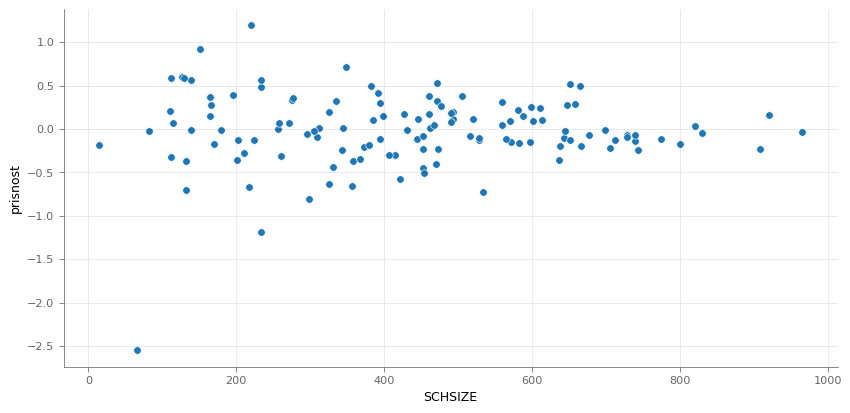

In [275]:
sns.scatterplot(x='SCHSIZE', y='prisnost', data=sch)

In [ ]:
sch[['SCHSIZE', 'prisnost']].corr()

### K čemu škola hodnocení používá

In [276]:
sch18_meta.variable_value_labels['SC154Q02WA']

{1.0: 'Yes',
 2.0: 'No',
 5.0: 'Valid Skip',
 7.0: 'Not Applicable',
 8.0: 'Invalid',
 9.0: 'No Response'}

In [ ]:
sch['SC154Q02WA'].value_counts()

In [278]:
selcols = [c for c in sch.columns if c.startswith('SC154')]

In [ ]:
foo = sch.groupby('prisnost_bin')[selcols + ['W_SCHGRNRABWT']].apply(nanaverage, weights='W_SCHGRNRABWT')

In [ ]:
foo.plot()

In [ ]:
foo.T.plot()

In [279]:
{k: v for k, v in sch18_meta.column_names_to_labels.items() if k in selcols}

{'SC154Q01HA': "School's use of assessments of students: To guide students' learning",
 'SC154Q02WA': "School's use of assessments of students: To inform parents about their child's progress",
 'SC154Q03WA': "School's use of assessments of students: To make decisions about students' retention or promotion",
 'SC154Q04WA': "School's use of assessments of students: To group students for instructional purposes",
 'SC154Q05WA': "School's use of assessments of students: To compare the school to <district or national> performance",
 'SC154Q06WA': "School's use of assessments of students: To monitor the school’s progress from year to year",
 'SC154Q07WA': "School's use of assessments of students: To make judgements about teachers' effectiveness",
 'SC154Q08WA': "School's use of assessments of students: To identify aspects of instruction or the curriculum that could be improved",
 'SC154Q09HA': "School's use of assessments of students: To adapt teaching to the students' needs",
 'SC154Q10WA': 

In [ ]:
sns.scatterplot(x='TEACHBEHA', y='prisnost', data=sch)

In [ ]:
sch18['SC001Q01TA'].value_counts()

In [269]:
sch18_meta.column_names_to_labels

NameError: name 'sch18_meta' is not defined